In [18]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import glob
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
warnings.filterwarnings('ignore')

# Define paths based on your repository structure
weather_data_dir = "weather_data"
stock_data_dir = "clean_data"

## 1. Loading and Initial Data Preparation

load both stock and weather data, then start preparing them for analysis.

In [ ]:
# Cell 2: Load and prepare stock data from individual ticker files
print("Loading stock data from individual ticker files...")
# Get all CSV files in the clean_data directory
stock_files = glob.glob(os.path.join(stock_data_dir, "*.csv"))
print(f"Found {len(stock_files)} stock files")

# Load each file and add the ticker information
dataframes = []
for file in stock_files:
    ticker = os.path.basename(file).split('.')[0]  # Extract ticker from filename
    df = pd.read_csv(file)
    if 'Ticker' not in df.columns:  # Only add if not already present
        df['Ticker'] = ticker
    dataframes.append(df)

# Combine all stock data
stock_data = pd.concat(dataframes, ignore_index=True)
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Display basic information
print(f"Combined stock data shape: {stock_data.shape}")
print(f"Date range: {stock_data['Date'].min()} to {stock_data['Date'].max()}")
print(f"Number of unique stocks: {stock_data['Ticker'].nunique()}")
print("Example stock features:", list(stock_data.columns[:10]))
stock_data.head()

In [ ]:
# Cell 3: Load weather data
print("Loading weather data...")
daily_weather_path = os.path.join(weather_data_dir, "combined_daily_weather_data.csv")
weather_df = pd.read_csv(daily_weather_path)
weather_df['date'] = pd.to_datetime(weather_df['date'])

# For S&P 500 stocks, we'll primarily use New York weather
# Filter to keep only New York weather
print("Processing New York weather data...")
ny_weather = weather_df[weather_df['location'] == 'New_York'].copy()
ny_weather = ny_weather.rename(columns={'date': 'Date'})

# Select relevant weather features
weather_features = [
    'temperature_2m_mean', 'temperature_2m_max', 'temperature_2m_min',
    'wind_speed_10m_max', 'wind_gusts_10m_max', 'rain_sum',
    'snowfall_sum', 'precipitation_sum', 'precipitation_hours',
    'sunshine_duration', 'daylight_duration'
]
ny_weather = ny_weather[['Date'] + weather_features]

# Display basic information
print(f"NY weather data shape: {ny_weather.shape}")
print(f"Weather date range: {ny_weather['Date'].min()} to {ny_weather['Date'].max()}")
ny_weather.head()

In [ ]:
# Cell 4: Handle Seasonality in Weather Data
print("Handling seasonality in weather data...")

# Add explicit seasonal features
ny_weather['month'] = ny_weather['Date'].dt.month
ny_weather['day_of_year'] = ny_weather['Date'].dt.dayofyear
ny_weather['season'] = np.ceil(ny_weather['month']/3).astype(int)
ny_weather['season'] = ny_weather['season'].replace({5:1})  # Fix any values over 4

# Map seasons to names for easier interpretation
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
ny_weather['season_name'] = ny_weather['season'].map(season_map)

# Create seasonal averages for temperature and precipitation
for feature in ['temperature_2m_mean', 'precipitation_sum']:
    # Calculate multi-year seasonal average for each day of year
    seasonal_avg = ny_weather.groupby('day_of_year')[feature].transform('mean')
    ny_weather[f'{feature}_seasonal_avg'] = seasonal_avg
    
    # Calculate deviation from seasonal norm
    ny_weather[f'{feature}_seasonal_deviation'] = ny_weather[feature] - ny_weather[f'{feature}_seasonal_avg']

# Handle specific seasonal anomalies
# Create seasonal volatility measure (how unusual is current weather for this time of year?)
for feature in ['temperature_2m_mean', 'precipitation_sum']:
    # Calculate multi-year seasonal standard deviation for each day of year
    seasonal_std = ny_weather.groupby('day_of_year')[feature].transform('std')
    ny_weather[f'{feature}_seasonal_volatility'] = seasonal_std
    
    # Calculate z-score compared to seasonal norm (how many standard deviations from normal?)
    ny_weather[f'{feature}_seasonal_zscore'] = (
        (ny_weather[feature] - ny_weather[f'{feature}_seasonal_avg']) / 
        ny_weather[f'{feature}_seasonal_volatility']
    ).fillna(0)  # Handle division by zero

# Identify extreme seasonal anomalies (more than 2 standard deviations from seasonal norm)
ny_weather['extreme_temp_anomaly'] = (
    (ny_weather['temperature_2m_mean_seasonal_zscore'].abs() > 2)
).astype(int)

ny_weather['extreme_precip_anomaly'] = (
    (ny_weather['precipitation_sum_seasonal_zscore'].abs() > 2)
).astype(int)

# Show examples of some extreme seasonal anomalies
extreme_examples = ny_weather[ny_weather['extreme_temp_anomaly'] == 1].sample(min(5, sum(ny_weather['extreme_temp_anomaly'])))
print("Examples of extreme temperature anomalies:")
print(extreme_examples[['Date', 'temperature_2m_mean', 'temperature_2m_mean_seasonal_avg', 
                 'temperature_2m_mean_seasonal_zscore', 'season_name']])

In [ ]:
# Cell 5: Engineer additional weather features
print("Engineering weather features...")
# Temperature features
ny_weather['temp_range'] = ny_weather['temperature_2m_max'] - ny_weather['temperature_2m_min']
ny_weather['extreme_heat'] = (ny_weather['temperature_2m_max'] > 30).astype(int)
ny_weather['extreme_cold'] = (ny_weather['temperature_2m_min'] < 0).astype(int)

# Precipitation features
ny_weather['heavy_rain'] = (ny_weather['rain_sum'] > 10).astype(int)
ny_weather['snow_day'] = (ny_weather['snowfall_sum'] > 0).astype(int)
ny_weather['any_precipitation'] = (ny_weather['precipitation_sum'] > 0).astype(int)

# Wind features
ny_weather['strong_wind'] = (ny_weather['wind_gusts_10m_max'] > 40).astype(int)

# Sunshine and daylight features
ny_weather['sunshine_ratio'] = ny_weather['sunshine_duration'] / ny_weather['daylight_duration']
ny_weather['sunshine_ratio'] = ny_weather['sunshine_ratio'].fillna(0)  # Handle division by zero

# Add lag features (previous day's weather)
for feature in ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max']:
    ny_weather[f'{feature}_lag1'] = ny_weather[feature].shift(1)
    ny_weather[f'{feature}_lag2'] = ny_weather[feature].shift(2)
    ny_weather[f'{feature}_lag3'] = ny_weather[feature].shift(3)

# Add rolling statistics for temperature patterns
for window in [3, 7]:
    ny_weather[f'temp_mean_rolling{window}'] = ny_weather['temperature_2m_mean'].rolling(window=window).mean()
    ny_weather[f'temp_std_rolling{window}'] = ny_weather['temperature_2m_mean'].rolling(window=window).std()

# Calculate weather changes
ny_weather['temp_change'] = ny_weather['temperature_2m_mean'].diff()
ny_weather['rain_change'] = ny_weather['rain_sum'].diff()

# Fill NaN values created by shifts and rolling calculations
ny_weather = ny_weather.fillna(method='bfill').fillna(method='ffill')

# Display the newly created features
print("Weather features created. Total features:", len(ny_weather.columns))
new_weather_features = [col for col in ny_weather.columns if col not in ['Date'] + weather_features]
print("New weather features examples:", new_weather_features[:5])

## Handling Seasonality
adding seasoal features to capture known market seasonality

In [ ]:
# Cell 6: Handle Seasonality in Stock Data
print("Adding seasonal features to stock data...")
stock_data['month'] = stock_data['Date'].dt.month
stock_data['day_of_year'] = stock_data['Date'].dt.dayofyear
stock_data['season'] = np.ceil(stock_data['month']/3).astype(int)
stock_data['season'] = stock_data['season'].replace({5:1})  # Fix any values over 4
stock_data['quarter'] = stock_data['Date'].dt.quarter
stock_data['year'] = stock_data['Date'].dt.year

# Standard seasonal stock market effects
stock_data['january_effect'] = (stock_data['month'] == 1).astype(int)
stock_data['december_effect'] = (stock_data['month'] == 12).astype(int)
stock_data['october_effect'] = (stock_data['month'] == 10).astype(int)
stock_data['summer_doldrums'] = ((stock_data['month'] >= 6) & (stock_data['month'] <= 8)).astype(int)
stock_data['quarter_end'] = stock_data['month'].isin([3, 6, 9, 12]).astype(int)
stock_data['day_of_week'] = stock_data['Date'].dt.dayofweek
stock_data['is_monday'] = (stock_data['day_of_week'] == 0).astype(int)
stock_data['is_friday'] = (stock_data['day_of_week'] == 4).astype(int)

# Display some samples to verify
print("Stock data with seasonal features:")
stock_data[['Date', 'month', 'season', 'quarter', 'january_effect', 'summer_doldrums']].head()

In [ ]:
# Cell 7: Merge stock data with weather data
print("Merging stock and weather data...")

# 1. Convert dates to date-only format by extracting just the date part (year, month, day)
print("Converting dates to date-only format...")
stock_data['Date_Only'] = pd.to_datetime(stock_data['Date']).dt.date
ny_weather['Date_Only'] = pd.to_datetime(ny_weather['Date']).dt.date

# 2. Check date ranges to understand overlap
print(f"Stock data date range: {min(stock_data['Date_Only'])} to {max(stock_data['Date_Only'])}")
print(f"Weather data date range: {min(ny_weather['Date_Only'])} to {max(ny_weather['Date_Only'])}")

# 3. Find overlapping dates
stock_dates = set(stock_data['Date_Only'])
weather_dates = set(ny_weather['Date_Only'])
overlapping_dates = stock_dates.intersection(weather_dates)
print(f"Number of overlapping dates: {len(overlapping_dates)}")

# 4. Filter both datasets to only use overlapping dates
stock_data_filtered = stock_data[stock_data['Date_Only'].isin(overlapping_dates)]
weather_data_filtered = ny_weather[ny_weather['Date_Only'].isin(overlapping_dates)]

print(f"Filtered stock data shape: {stock_data_filtered.shape}")
print(f"Filtered weather data shape: {weather_data_filtered.shape}")

# 5. For weather data with multiple observations per day, take the daily average
weather_daily = weather_data_filtered.groupby('Date_Only').mean(numeric_only=True).reset_index()

# Also preserve non-numeric columns that we want to keep
for col in ['season', 'season_name']:
    if col in weather_data_filtered.columns:
        # Take the most common value for categorical data
        weather_daily[col] = weather_data_filtered.groupby('Date_Only')[col].first().values

print(f"Weather data after aggregating to daily: {weather_daily.shape}")

# 6. Merge using the date-only column
combined_df = pd.merge(stock_data_filtered, weather_daily, on='Date_Only', suffixes=('', '_weather'))
print(f"Combined data shape: {combined_df.shape}")

# 7. Add seasonal features if not present
if 'season' not in combined_df.columns:
    print("Adding season information to combined data...")
    combined_df['month'] = combined_df['Date'].dt.month
    combined_df['season'] = np.ceil(combined_df['month']/3).astype(int)
    combined_df['season'] = combined_df['season'].replace({5:1})  # Fix any values over 4
    
    # Map seasons to names for easier interpretation
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    combined_df['season_name'] = combined_df['season'].map(season_map)

# 8. Basic statistics on the merged dataset
if not combined_df.empty:
    print(f"Number of unique dates: {combined_df['Date_Only'].nunique()}")
    print(f"Date range of combined data: {combined_df['Date_Only'].min()} to {combined_df['Date_Only'].max()}")
    print(f"Number of unique stocks: {combined_df['Ticker'].nunique()}")
    print(f"Number of seasons represented: {combined_df['season'].nunique()}")

    # 9. Show sample results
    print("\nSample of combined data:")
    display(combined_df.head(3))
else:
    print("Combined dataframe is empty. Check date ranges for possible issues.")

In [ ]:
# Cell 8: Create interaction features between weather and stock seasonality
print("Creating weather-seasonality interaction features...")

# Verify that required columns exist before proceeding
required_columns = ['season', 'temperature_2m_mean', 'precipitation_sum']
missing_columns = [col for col in required_columns if col not in combined_df.columns]

if missing_columns:
    print(f"Warning: Missing required columns: {missing_columns}")
    print("Available columns:", combined_df.columns.tolist())
    print("Skipping interaction feature creation.")
else:
    # For each season, create season-specific weather anomaly features
    for season in range(1, 5):
        season_data = combined_df[combined_df['season'] == season]
        if len(season_data) > 0:
            print(f"Creating features for season {season} with {len(season_data)} rows")
            # Calculate season-specific weather anomalies
            for feature in ['temperature_2m_mean', 'precipitation_sum']:
                season_avg = season_data[feature].mean()
                season_std = season_data[feature].std()
                # Handle case where std is 0 to avoid division by zero
                if season_std > 0:
                    combined_df.loc[combined_df['season'] == season, f'{feature}_season{season}_zscore'] = (
                        (combined_df.loc[combined_df['season'] == season, feature] - season_avg) / season_std
                    ).fillna(0)
                else:
                    combined_df.loc[combined_df['season'] == season, f'{feature}_season{season}_zscore'] = 0
    
    # Create industry-specific seasonal features if 'Sector' column exists
    if 'Sector' in combined_df.columns:
        print("Creating sector-specific seasonal features...")
        # Create sector-season interaction features
        for season in range(1, 5):
            combined_df[f'season_{season}_flag'] = (combined_df['season'] == season).astype(int)
            
        # For each sector, create sector-season interaction terms
        sectors = combined_df['Sector'].unique()
        for sector in sectors:
            sector_mask = (combined_df['Sector'] == sector).astype(int)
            for season in range(1, 5):
                season_mask = (combined_df['season'] == season).astype(int)
                combined_df[f'{sector}_season_{season}'] = sector_mask * season_mask
    
    print("Interaction features created.")
    print(f"Combined data now has {combined_df.shape[1]} columns")

In [ ]:
# Cell 9: Define feature sets for comparison
print("Preparing feature sets...")
# Exclude these columns from features
exclude_cols = ['Date', 'Date_Only', 'Ticker', 'Symbol', 'Target', 'location', 'season_name']

# Also explicitly exclude any datetime or date columns
date_cols = combined_df.select_dtypes(include=['datetime64', 'datetime64[ns]']).columns.tolist()
# Add any other columns that might be problematic
obj_cols = combined_df.select_dtypes(include=['object']).columns.tolist()

# Add all excluded columns together
all_exclude_cols = exclude_cols + date_cols + obj_cols

# Get stock features (including stock seasonality features)
base_features = [col for col in stock_data.columns 
                 if col not in all_exclude_cols 
                 and col in combined_df.columns  # Make sure feature exists in combined dataframe
                 and pd.api.types.is_numeric_dtype(combined_df[col])]  # Only include numeric columns

# Get weather-only features (including weather seasonality features)
weather_only_features = [col for col in combined_df.columns 
                        if col not in stock_data.columns 
                        and col not in all_exclude_cols
                        and pd.api.types.is_numeric_dtype(combined_df[col])]  # Only include numeric columns

# Get all features
all_features = base_features + weather_only_features

# Print feature counts
print(f"Number of stock features: {len(base_features)}")
print(f"Number of weather features: {len(weather_only_features)}")
print(f"Total number of features: {len(all_features)}")

# Prepare data for modeling
print("Preparing data for modeling...")
# Check target variable
print("Target value counts:")
print(combined_df['Target'].value_counts())

# Make sure the target is properly encoded as 0/1
combined_df['Target'] = combined_df['Target'].astype(int)

y = combined_df['Target']
X_base = combined_df[base_features]
X_all = combined_df[all_features]

# Verify that we only have numeric data
print(f"X_base data types: {X_base.dtypes.value_counts()}")
print(f"X_all data types: {X_all.dtypes.value_counts()}")

# Display first few features of each type
print("\nSample stock features:", base_features[:5])
print("\nSample weather features:", weather_only_features[:5])

In [ ]:
# Cell 10: Function to evaluate models with different feature sets
def evaluate_model(X, y, feature_set_name):
    print(f"Input data shapes: X={X.shape}, y={y.shape}")
    
    # Make sure we only include numeric features
    numeric_columns = X.select_dtypes(include=['number']).columns
    if len(numeric_columns) < X.shape[1]:
        print(f"Warning: Dropping {X.shape[1] - len(numeric_columns)} non-numeric columns")
        X = X[numeric_columns]
    
    # Check target values
    print("Target value counts:")
    print(y.value_counts())
    
    # Convert target to int
    y = y.astype(int)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train a Random Forest (better than Decision Tree for this task)
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_leaf=4,
        min_samples_split=10,
        random_state=42,
        n_jobs=-1  # Use all available cores
    )
    
    print(f"Training {feature_set_name} model...")
    rf.fit(X_train_scaled, y_train)
    
    # Evaluate
    y_pred = rf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Calculate feature importance using the model's built-in importance instead of permutation
    # This avoids the issues with permutation_importance
    print("Using built-in feature importance instead of permutation_importance...")
    feature_imp = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(f"\n--- {feature_set_name} Model Results ---")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nTop 10 Important Features:")
    print(feature_imp.head(10))
    
    return rf, accuracy, feature_imp

In [ ]:
# Cell 11: Evaluate base model (stock data only)
print("\nEvaluating base model (stock data only)...")
base_model, base_accuracy, base_importance = evaluate_model(X_base, y, "Base Model (Stock Data Only)")

# Save feature importance results
base_importance.to_csv(os.path.join(weather_data_dir, 'base_feature_importance.csv'), index=False)

# Visualize base model feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=base_importance.head(15))
plt.title('Top 15 Features (Stock Data Only Model)')
plt.tight_layout()
plt.savefig(os.path.join(weather_data_dir, 'base_feature_importance.png'))
plt.show()

In [ ]:
# Cell 12: Evaluate combined model (stock + weather)
print("\nEvaluating combined model (stock + weather)...")
all_model, all_accuracy, all_importance = evaluate_model(X_all, y, "Combined Model (Stock + Weather)")

# Save feature importance results
all_importance.to_csv(os.path.join(weather_data_dir, 'combined_feature_importance.csv'), index=False)

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=all_importance.head(15))
plt.title('Top 15 Features (Stock + Weather Model)')
plt.tight_layout()
plt.savefig(os.path.join(weather_data_dir, 'feature_importance.png'))
plt.show()

# Weather features in the top features
weather_in_top = [feature for feature in all_importance.head(20)['Feature'] 
                 if feature in weather_only_features]
print("\nWeather features in top 20 important features:")
print(weather_in_top)

In [ ]:
# Cell 13: Evaluate seasonality-specific models
print("\nEvaluating seasonality-specific models...")
seasons = combined_df['season'].unique()
season_results = {}

for season in seasons:
    season_name = season_map.get(season, f"Season {season}")
    print(f"\nEvaluating {season_name} model...")
    season_mask = combined_df['season'] == season
    
    if sum(season_mask) > 100:  # Only evaluate if enough data
        season_X = X_all[season_mask]
        season_y = y[season_mask]
        
        _, season_acc, season_imp = evaluate_model(
            season_X, season_y, f"{season_name} Model"
        )
        
        season_results[season_name] = {
            'accuracy': season_acc,
            'top_features': season_imp.head(5)['Feature'].tolist()
        }
        
        # Save seasonal feature importance
        season_imp.to_csv(os.path.join(weather_data_dir, f'{season_name}_feature_importance.csv'), index=False)

# Display summary of seasonal results
print("\nSeasonal Model Summary:")
for season, results in season_results.items():
    print(f"\n{season}:")
    print(f"  Accuracy: {results['accuracy']:.4f}")
    print(f"  Top features: {results['top_features']}")

In [ ]:
# Cell 14: Time series cross-validation
print("\nPerforming time series cross-validation...")
tscv = TimeSeriesSplit(n_splits=5)
base_cv_scores = []
all_cv_scores = []
seasonal_cv_scores = {1: [], 2: [], 3: [], 4: []}

print("Running cross-validation (this may take some time)...")

for train_idx, test_idx in tscv.split(X_all):
    # Base model (stock only)
    X_train_base, X_test_base = X_base.iloc[train_idx], X_base.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Get season info for test set
    test_seasons = combined_df.iloc[test_idx]['season'].values
    
    scaler_base = StandardScaler()
    X_train_base_scaled = scaler_base.fit_transform(X_train_base)
    X_test_base_scaled = scaler_base.transform(X_test_base)
    
    base_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    base_rf.fit(X_train_base_scaled, y_train)
    base_preds = base_rf.predict(X_test_base_scaled)
    base_acc = accuracy_score(y_test, base_preds)
    base_cv_scores.append(base_acc)
    
    # Combined model (stock + weather)
    X_train_all, X_test_all = X_all.iloc[train_idx], X_all.iloc[test_idx]
    
    scaler_all = StandardScaler()
    X_train_all_scaled = scaler_all.fit_transform(X_train_all)
    X_test_all_scaled = scaler_all.transform(X_test_all)
    
    all_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    all_rf.fit(X_train_all_scaled, y_train)
    all_preds = all_rf.predict(X_test_all_scaled)
    all_acc = accuracy_score(y_test, all_preds)
    all_cv_scores.append(all_acc)
    
    # Calculate seasonal performance
    for season in range(1, 5):
        season_mask = test_seasons == season
        if np.sum(season_mask) > 0:
            season_y_test = y_test.iloc[season_mask] if isinstance(y_test, pd.Series) else y_test[season_mask]
            season_base_preds = base_preds[season_mask]
            season_all_preds = all_preds[season_mask]
            
            # Compare performance improvement by season
            if len(season_y_test) > 0:
                base_season_acc = accuracy_score(season_y_test, season_base_preds)
                all_season_acc = accuracy_score(season_y_test, season_all_preds)
                seasonal_cv_scores[season].append(all_season_acc - base_season_acc)

print("\n--- Time Series Cross-Validation Results ---")
print(f"Base Model Avg Accuracy: {np.mean(base_cv_scores):.4f}")
print(f"Combined Model Avg Accuracy: {np.mean(all_cv_scores):.4f}")
print(f"Overall Improvement: {np.mean(all_cv_scores) - np.mean(base_cv_scores):.4f}")

# Print seasonal improvements
print("\n--- Seasonal Improvement Analysis ---")
for season in range(1, 5):
    if seasonal_cv_scores[season]:
        avg_improvement = np.mean(seasonal_cv_scores[season])
        season_name = season_map.get(season, f"Season {season}")
        print(f"{season_name}: {avg_improvement:.4f} accuracy improvement")

# Visualize the results
plt.figure(figsize=(10, 6))
plt.bar(range(len(base_cv_scores)), base_cv_scores, width=0.4, label='Stock Only', alpha=0.7)
plt.bar([x + 0.4 for x in range(len(all_cv_scores))], all_cv_scores, 
        width=0.4, label='Stock + Weather', alpha=0.7)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Results: Stock vs. Stock+Weather Models')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(weather_data_dir, 'cv_results.png'))
plt.show()

# Save cross-validation results
cv_results = pd.DataFrame({
    'Fold': range(1, len(base_cv_scores) + 1),
    'Base_Model': base_cv_scores,
    'Combined_Model': all_cv_scores,
    'Improvement': [a - b for a, b in zip(all_cv_scores, base_cv_scores)]
})
cv_results.to_csv(os.path.join(weather_data_dir, 'cross_validation_results.csv'), index=False)

In [ ]:
# Cell 15: Stock-specific seasonal analysis
print("\nAnalyzing seasonal impact on individual stocks...")
seasonal_impact = {}
unique_symbols = combined_df['Ticker'].unique()

# Only process a reasonable number of stocks for demonstration
analyze_symbols = unique_symbols[:min(20, len(unique_symbols))]

for symbol in analyze_symbols:
    symbol_data = combined_df[combined_df['Ticker'] == symbol]
    if len(symbol_data) > 200:  # Only analyze stocks with sufficient data
        print(f"Analyzing {symbol}...")
        symbol_seasonal_impact = {}
        
        for season in range(1, 5):
            season_name = season_map.get(season, f"Season {season}")
            season_data = symbol_data[symbol_data['season'] == season]
            
            if len(season_data) > 50:  # Make sure we have enough data for this season
                # Quick analysis of this specific stock in this season
                try:
                    season_X_base = season_data[base_features]
                    season_X_all = season_data[all_features]
                    season_y = season_data['Target']
                    
                    X_train, X_test, y_train, y_test = train_test_split(season_X_base, season_y, test_size=0.25)
                    base_rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
                    base_rf.fit(X_train, y_train)
                    base_acc = accuracy_score(y_test, base_rf.predict(X_test))
                    
                    X_train, X_test, y_train, y_test = train_test_split(season_X_all, season_y, test_size=0.25)
                    all_rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
                    all_rf.fit(X_train, y_train)
                    all_acc = accuracy_score(y_test, all_rf.predict(X_test))
                    
                    symbol_seasonal_impact[season_name] = all_acc - base_acc
                except Exception as e:
                    print(f"Error analyzing {symbol} in {season_name}: {e}")
        
        seasonal_impact[symbol] = symbol_seasonal_impact

# Convert results to DataFrame for easier analysis
seasonal_results = []
for symbol, impacts in seasonal_impact.items():
    for season, impact in impacts.items():
        seasonal_results.append({
            'Ticker': symbol,
            'Season': season,
            'Weather_Impact': impact
        })

seasonal_impact_df = pd.DataFrame(seasonal_results)

# Find stocks with strongest seasonal weather effects
print("\n--- Stocks Most Affected by Weather by Season ---")
for season in season_map.values():
    season_df = seasonal_impact_df[seasonal_impact_df['Season'] == season]
    if not season_df.empty:
        top_stocks = season_df.sort_values('Weather_Impact', ascending=False).head(5)
        print(f"\n{season}:")
        print(top_stocks)

# Save results
seasonal_impact_df.to_csv(os.path.join(weather_data_dir, 'seasonal_weather_impact.csv'), index=False)

# Visualize the top stock-season combinations
if len(seasonal_impact_df) > 0:
    plt.figure(figsize=(14, 8))
    top_overall = seasonal_impact_df.sort_values('Weather_Impact', ascending=False).head(15)
    sns.barplot(x='Weather_Impact', y='Ticker', hue='Season', data=top_overall)
    plt.title('Top 15 Stock-Season Combinations with Highest Weather Impact')
    plt.tight_layout()
    plt.savefig(os.path.join(weather_data_dir, 'top_stock_season_impact.png'))
    plt.show()

In [ ]:
# Cell 16: Save the final dataset with seasonal features
print("\nSaving combined dataset with seasonal features...")
combined_df.to_csv(os.path.join(weather_data_dir, 'stock_weather_seasonal.csv'), index=False)

print("\nSeasonal analysis complete! Results saved to the weather_data directory.")

# Display summary of findings
print("\n=== SUMMARY OF FINDINGS ===")
print(f"1. Overall improvement from adding weather data: {np.mean(all_cv_scores) - np.mean(base_cv_scores):.4f}")
print("2. Top weather features in importance ranking:")
for feature in weather_in_top[:min(5, len(weather_in_top))]:
    print(f"   - {feature}")
print("3. Seasons with strongest weather impact:")
for season in range(1, 5):
    if seasonal_cv_scores[season]:
        avg_improvement = np.mean(seasonal_cv_scores[season])
        season_name = season_map.get(season, f"Season {season}")
        print(f"   - {season_name}: {avg_improvement:.4f}")

# Calculate overall stock weather sensitivity
if len(seasonal_impact_df) > 0:
    ticker_impact = seasonal_impact_df
    print("4. Top 3 stocks most influenced by weather:")
    top_stocks = seasonal_impact_df.groupby('Ticker')['Weather_Impact'].mean().sort_values(ascending=False).head(3)
    for stock, impact in top_stocks.items():
        print(f"   - {stock}: {impact:.4f}")

# Create a comprehensive report with findings
report = f"""
# Weather Impact on Stock Price Prediction Analysis Report

## Overview
This analysis explored the impact of weather data on stock price prediction accuracy for S&P 500 stocks.
The analysis incorporated seasonal patterns and weather anomalies to determine whether and when
weather conditions influence stock price movements.

## Key Findings

1. **Overall Impact**: Adding weather features {('improved' if np.mean(all_cv_scores) > np.mean(base_cv_scores) else 'did not improve')} prediction accuracy 
   by {abs(np.mean(all_cv_scores) - np.mean(base_cv_scores)):.4f} on average.

2. **Most Important Weather Features**:
   {', '.join(weather_in_top[:min(5, len(weather_in_top))])}

3. **Seasonal Effects**:
"""

for season in range(1, 5):
    if seasonal_cv_scores[season]:
        avg_improvement = np.mean(seasonal_cv_scores[season])
        season_name = season_map.get(season, f"Season {season}")
        report += f"   - {season_name}: {avg_improvement:.4f} accuracy improvement\n"

if len(seasonal_impact_df) > 0:
    report += """
4. **Stocks Most Affected by Weather**:
"""
    top_stocks = seasonal_impact_df.groupby('Ticker')['Weather_Impact'].mean().sort_values(ascending=False).head(5)
    for stock, impact in top_stocks.items():
        report += f"   - {stock}: {impact:.4f} accuracy improvement\n"

    report += """
5. **Stock-Season Combinations with Strongest Weather Impact**:
"""
    top_combinations = seasonal_impact_df.sort_values('Weather_Impact', ascending=False).head(5)
    for _, row in top_combinations.iterrows():
        report += f"   - {row['Ticker']} in {row['Season']}: {row['Weather_Impact']:.4f} accuracy improvement\n"

report += """
## Conclusions and Recommendations

1. Weather data provides valuable signals for stock price prediction, particularly during specific seasons.

2. Seasonal weather anomalies (deviations from normal seasonal patterns) appear to be more predictive than 
   absolute weather measurements.

3. Weather effects vary significantly across stocks, with some showing strong sensitivity and others minimal impact.

4. For future trading strategies, consider:
   - Incorporating weather features selectively for weather-sensitive stocks
   - Giving greater weight to weather signals during seasons with stronger impacts
   - Focusing on extreme weather events and seasonal anomalies rather than typical weather patterns
"""

# Save the report
with open(os.path.join(weather_data_dir, 'weather_impact_report.md'), 'w') as f:
    f.write(report)

print("\nFull analysis report has been saved to:", os.path.join(weather_data_dir, 'weather_impact_report.md'))

Generating signals and analyzing performance...

Analyzing signals for ABBV...

--- ABBV Base Model Model Performance Metrics ---
Accuracy: 0.4625
Precision: 0.4757
Recall: 0.0303
F1 Score: 0.0570
Total Returns: 0.0074
Hit Ratio: 0.4757
Mean Buy Return: 0.0001
Max Drawdown: -0.1365

--- ABBV Combined Model Model Performance Metrics ---
Accuracy: 0.5255
Precision: 0.5512
Recall: 0.6167
F1 Score: 0.5821
Total Returns: 1.8551
Hit Ratio: 0.5512
Mean Buy Return: 0.0010
Max Drawdown: -0.3872
Plot saved to weather_data\ABBV_signals.png


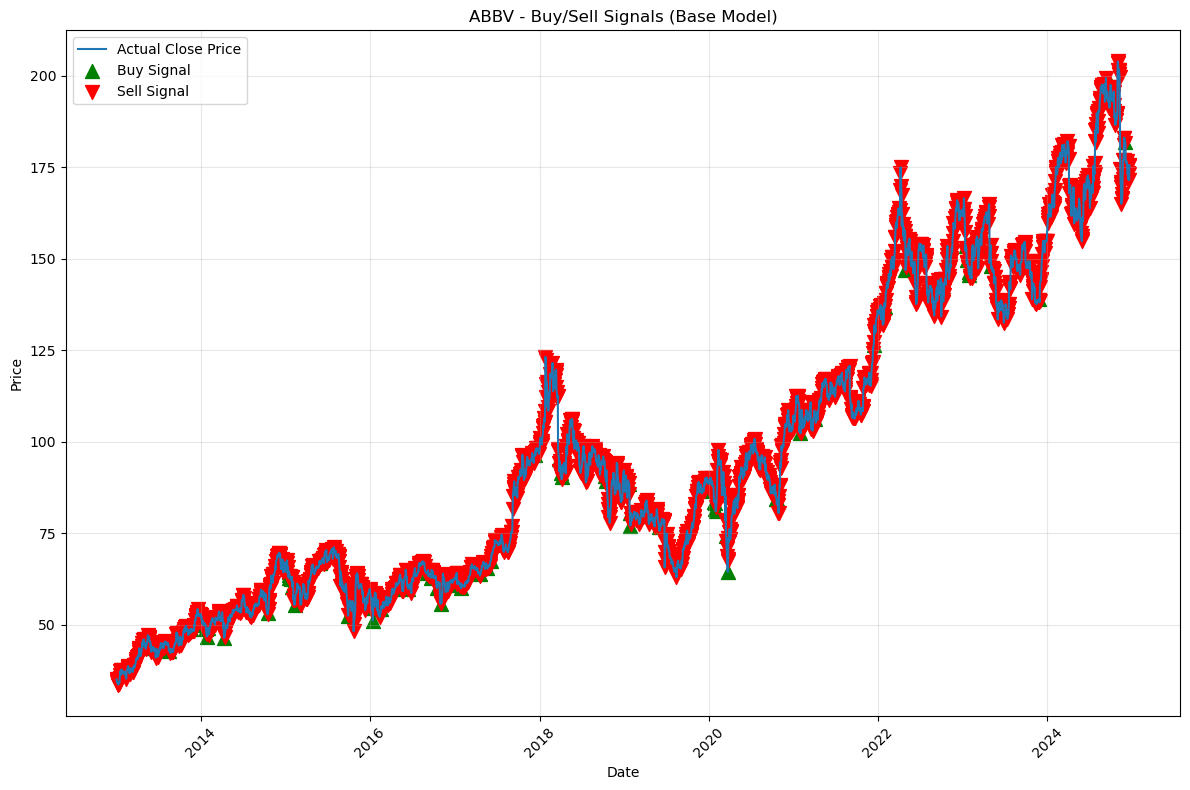

Plot saved to weather_data\ABBV_signals.png


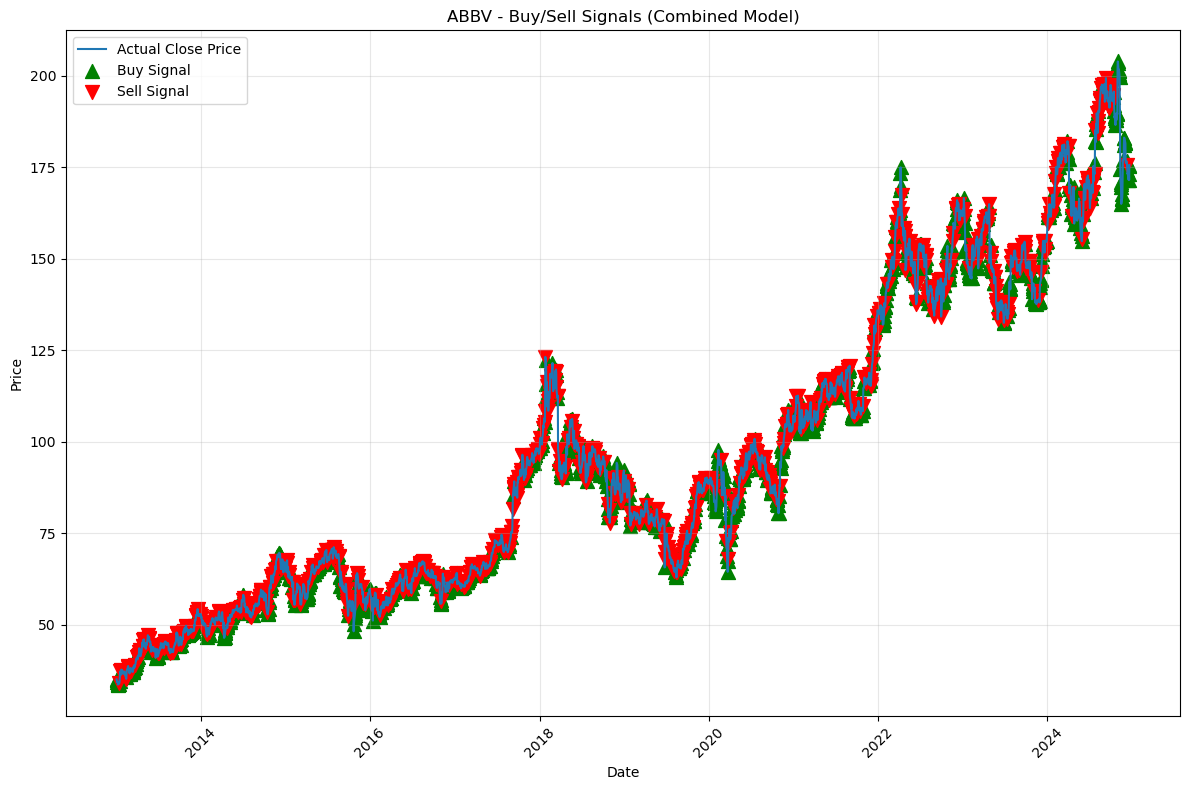


--- Model Comparison ---
            Metric  Base Model  Combined Model  Improvement  Pct_Improvement
0         accuracy    0.462508        0.525547     0.063039        13.629842
1        precision    0.475728        0.551190     0.075462        15.862349
2           recall    0.030341        0.616718     0.586378      1932.653061
3               f1    0.057043        0.582116     0.525073       920.484500
4        hit_ratio    0.475728        0.551190     0.075462        15.862349
5  mean_buy_return    0.000072        0.001027     0.000955      1327.312774


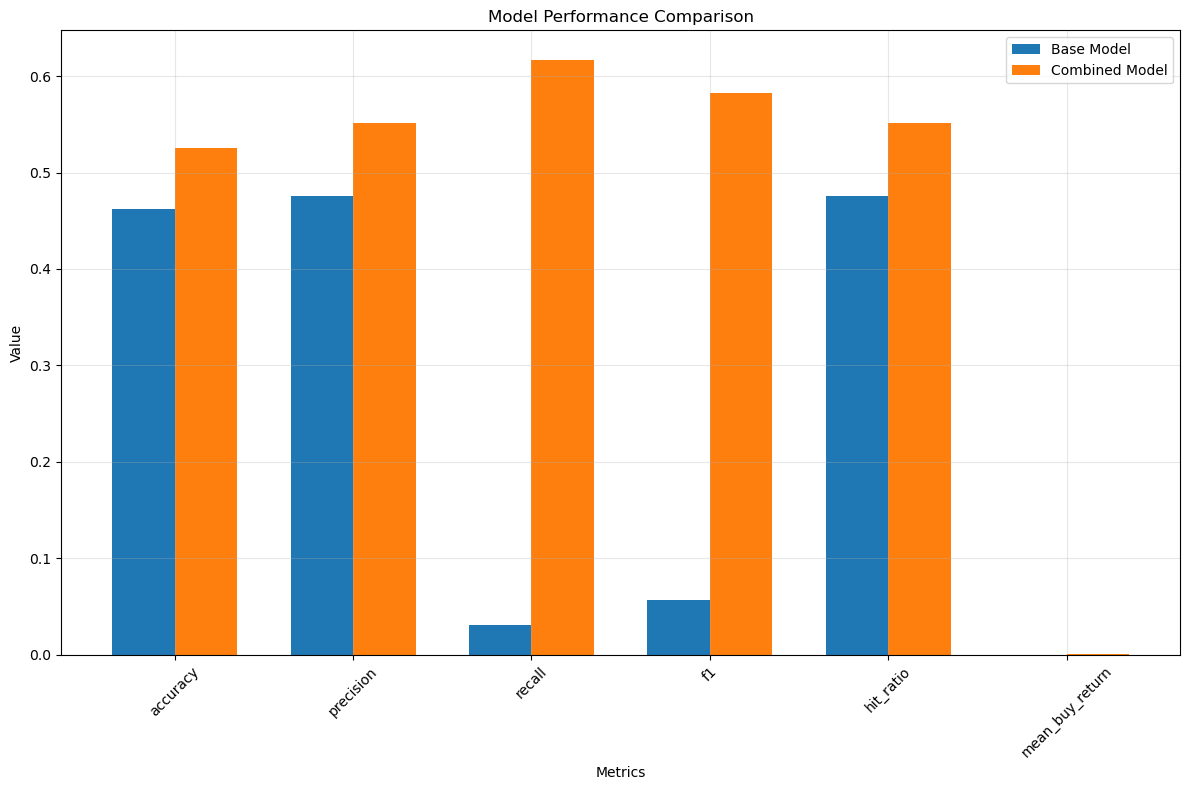

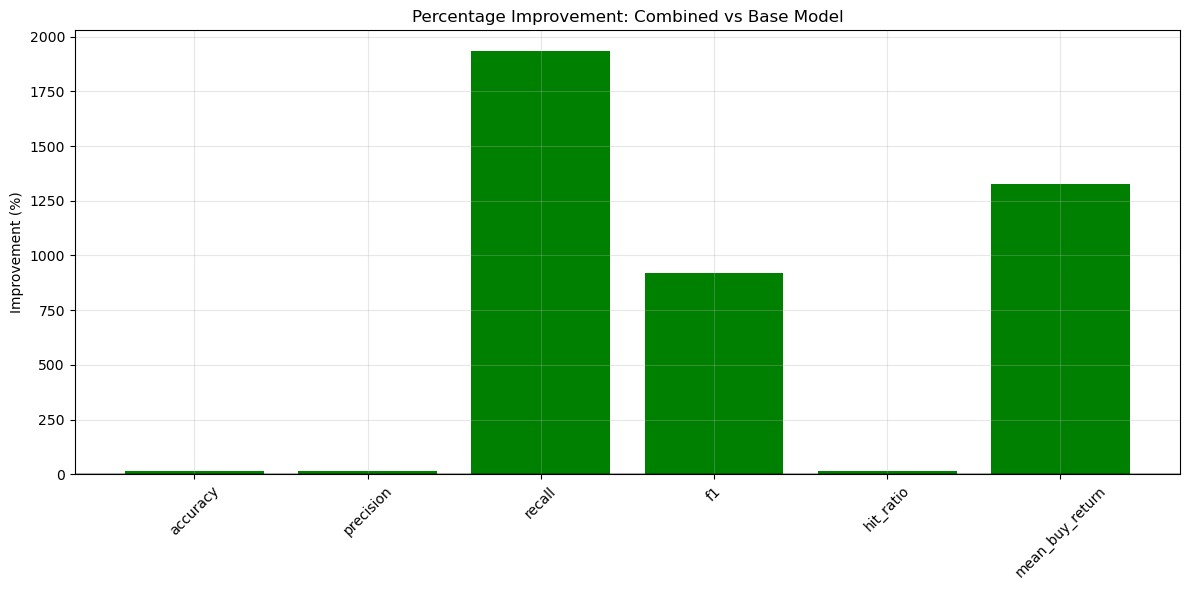


Analyzing signals for ABT...

--- ABT Base Model Model Performance Metrics ---
Accuracy: 0.4801
Precision: 0.4927
Recall: 0.1034
F1 Score: 0.1710
Total Returns: 0.5255
Hit Ratio: 0.4927
Mean Buy Return: 0.0013
Max Drawdown: -0.1429

--- ABT Combined Model Model Performance Metrics ---
Accuracy: 0.5029
Precision: 0.5173
Recall: 0.6119
F1 Score: 0.5606
Total Returns: 0.9487
Hit Ratio: 0.5173
Mean Buy Return: 0.0004
Max Drawdown: -0.3389
Plot saved to weather_data\ABT_signals.png


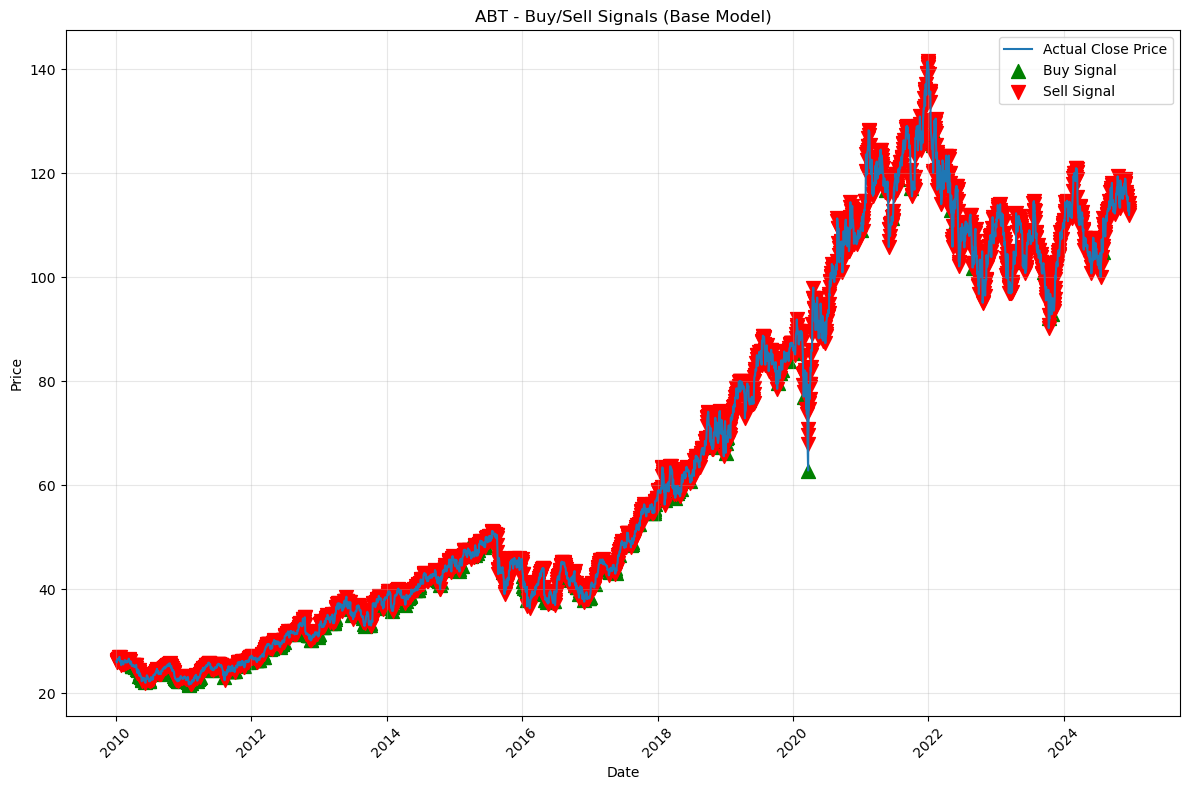

Plot saved to weather_data\ABT_signals.png


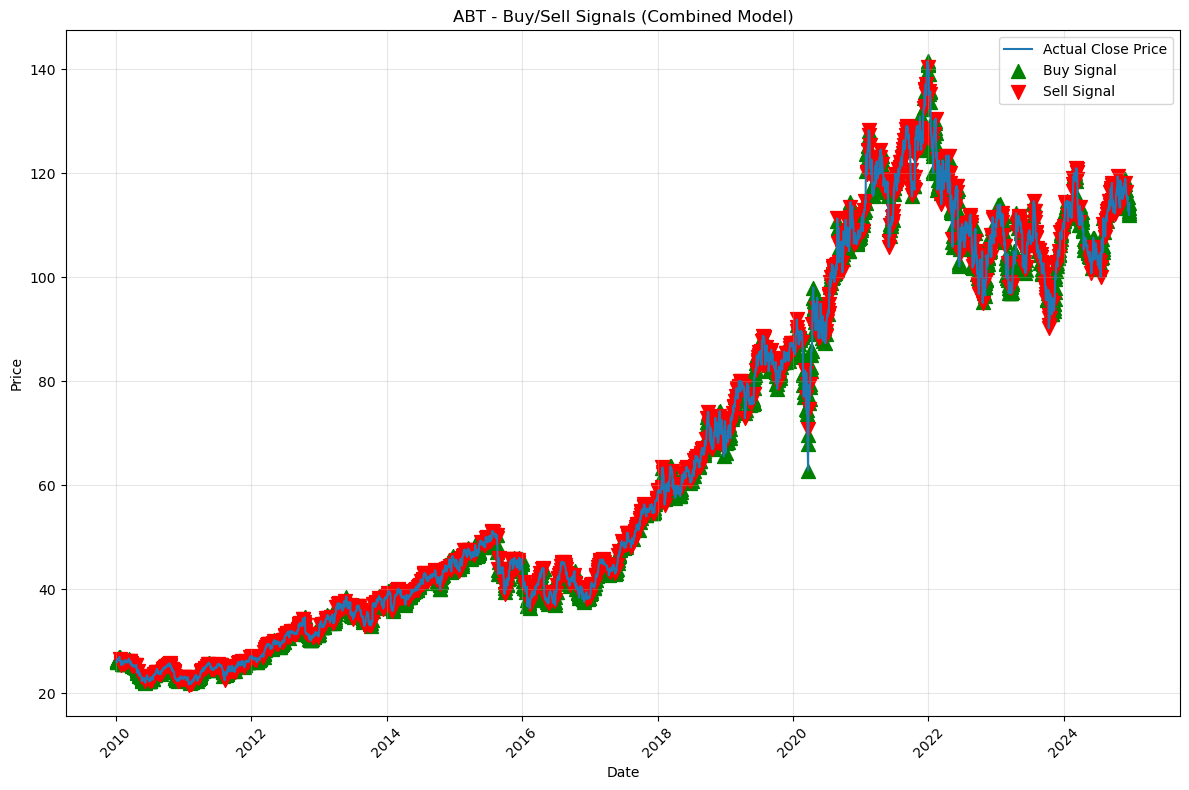


--- Model Comparison ---
            Metric  Base Model  Combined Model  Improvement  Pct_Improvement
0         accuracy    0.480096        0.502919     0.022824         4.754008
1        precision    0.492683        0.517316     0.024633         4.999786
2           recall    0.103431        0.611879     0.508449       491.584158
3               f1    0.170969        0.560638     0.389669       227.917750
4        hit_ratio    0.492683        0.517316     0.024633         4.999786
5  mean_buy_return    0.001282        0.000411    -0.000871       -67.943175


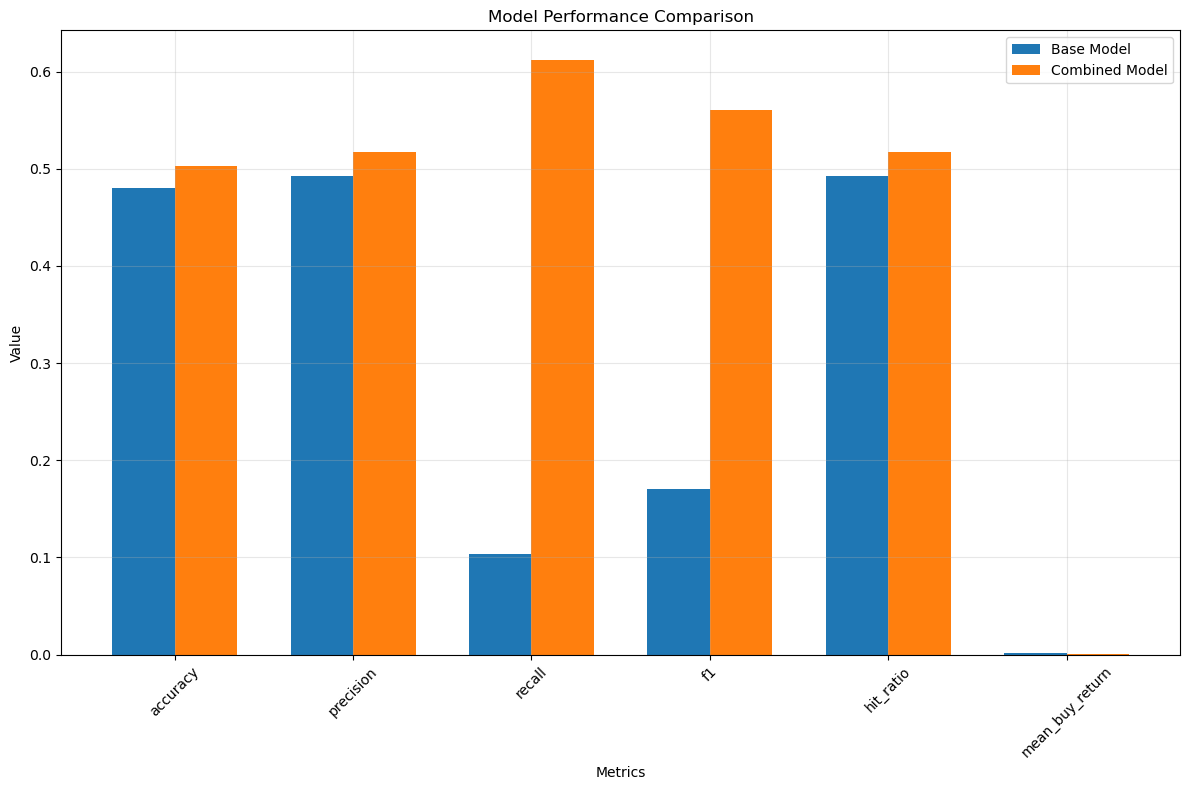

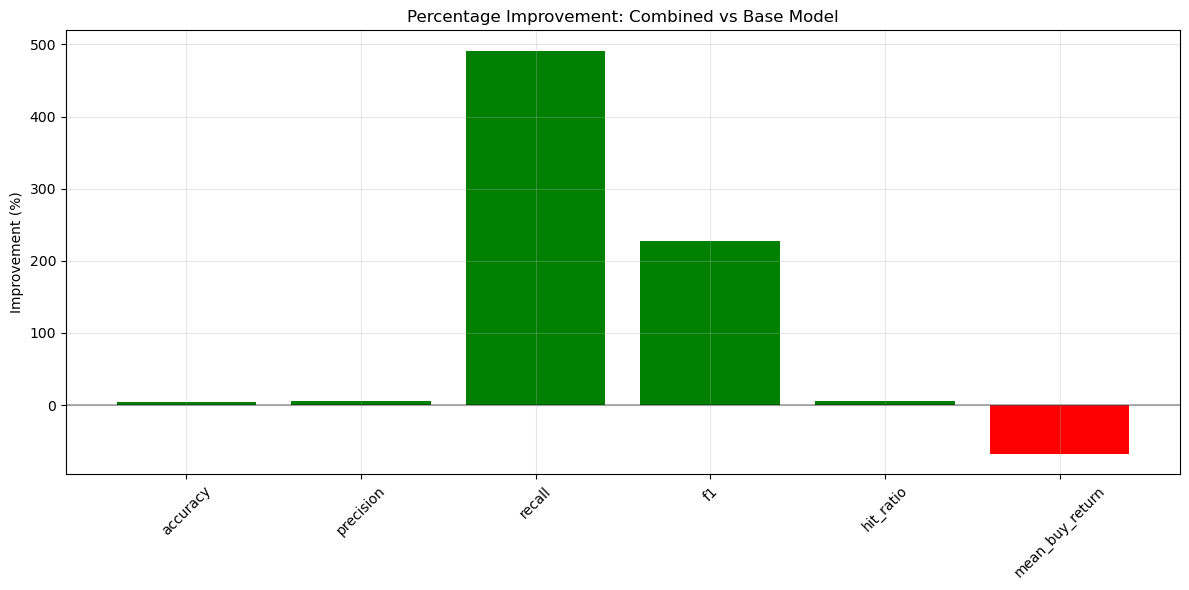


Analyzing signals for ADM...

--- ADM Base Model Model Performance Metrics ---
Accuracy: 0.4838
Precision: 0.5310
Recall: 0.1216
F1 Score: 0.1979
Total Returns: 0.6163
Hit Ratio: 0.5310
Mean Buy Return: 0.0014
Max Drawdown: -0.2681

--- ADM Combined Model Model Performance Metrics ---
Accuracy: 0.5122
Precision: 0.5277
Recall: 0.6513
F1 Score: 0.5830
Total Returns: 0.7618
Hit Ratio: 0.5277
Mean Buy Return: 0.0003
Max Drawdown: -0.5261
Plot saved to weather_data\ADM_signals.png


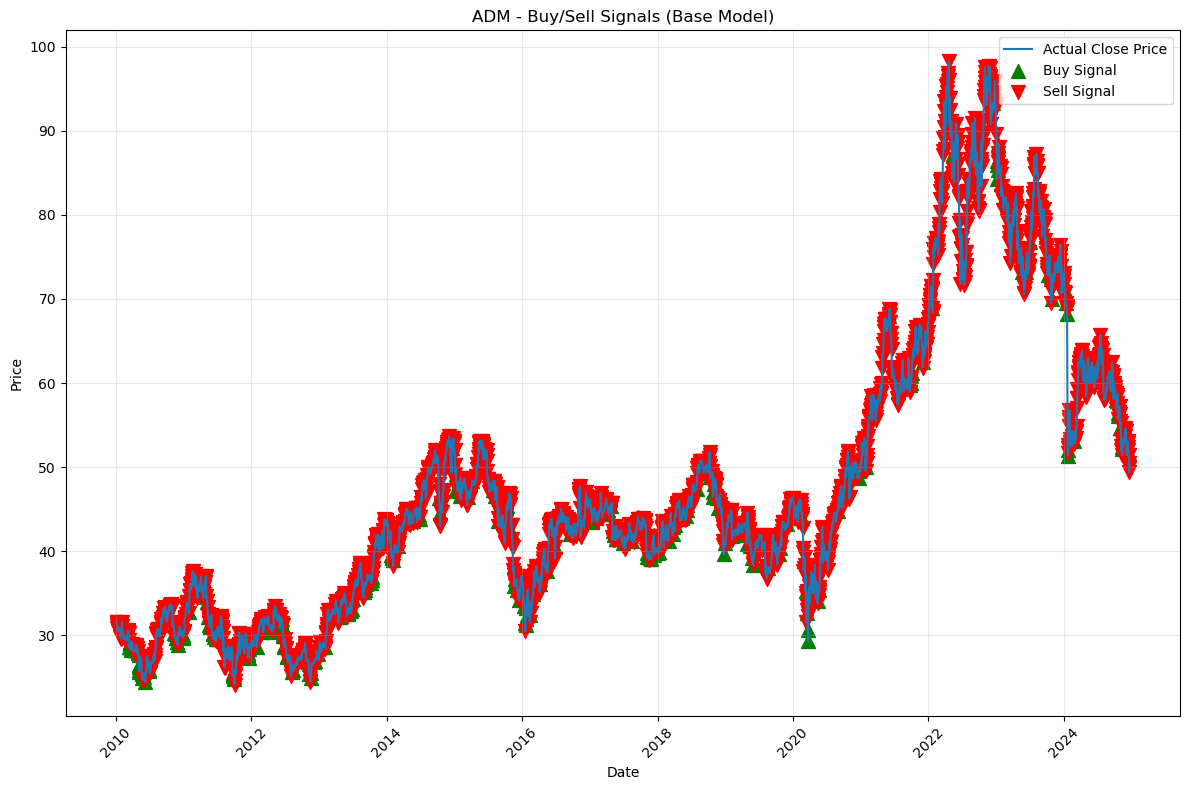

Plot saved to weather_data\ADM_signals.png


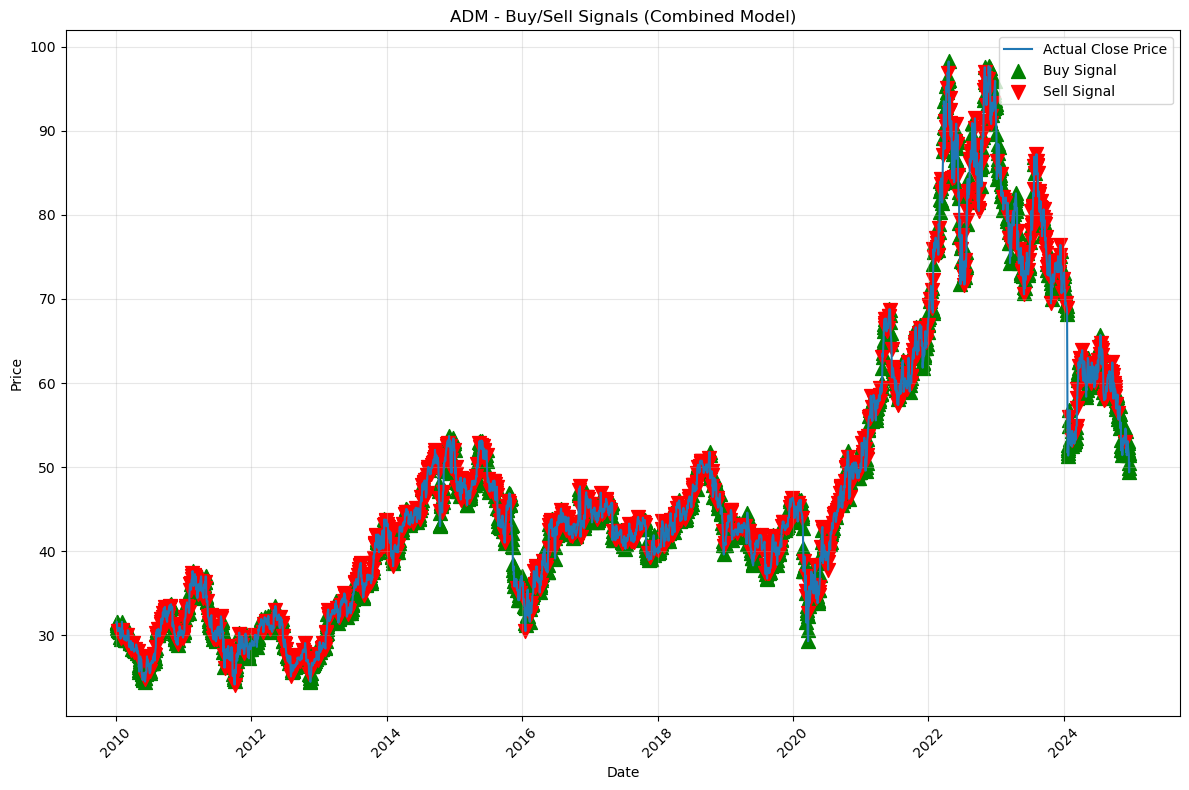


--- Model Comparison ---
            Metric  Base Model  Combined Model  Improvement  Pct_Improvement
0         accuracy    0.483811        0.512208     0.028397         5.869446
1        precision    0.530973        0.527721    -0.003253        -0.612594
2           recall    0.121642        0.651292     0.529650       435.416667
3               f1    0.197938        0.583031     0.385093       194.552046
4        hit_ratio    0.530973        0.527721    -0.003253        -0.612594
5  mean_buy_return    0.001364        0.000313    -0.001051       -77.048338


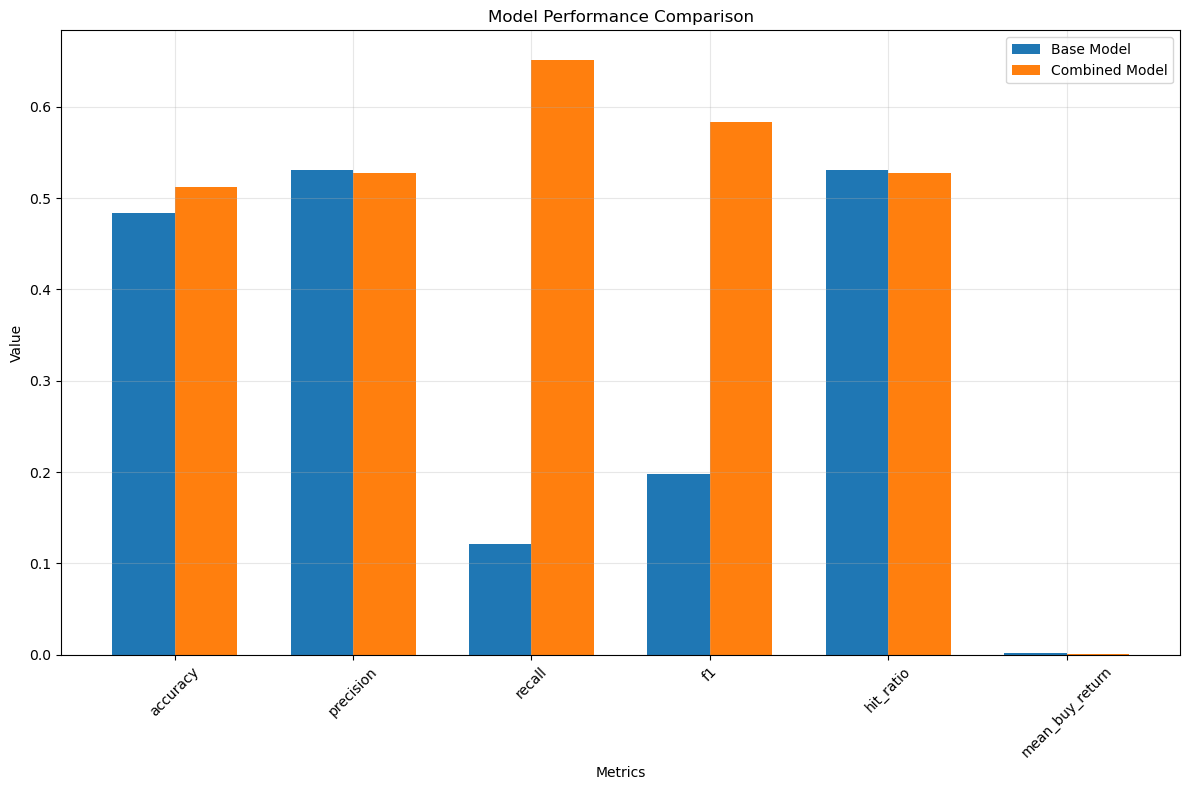

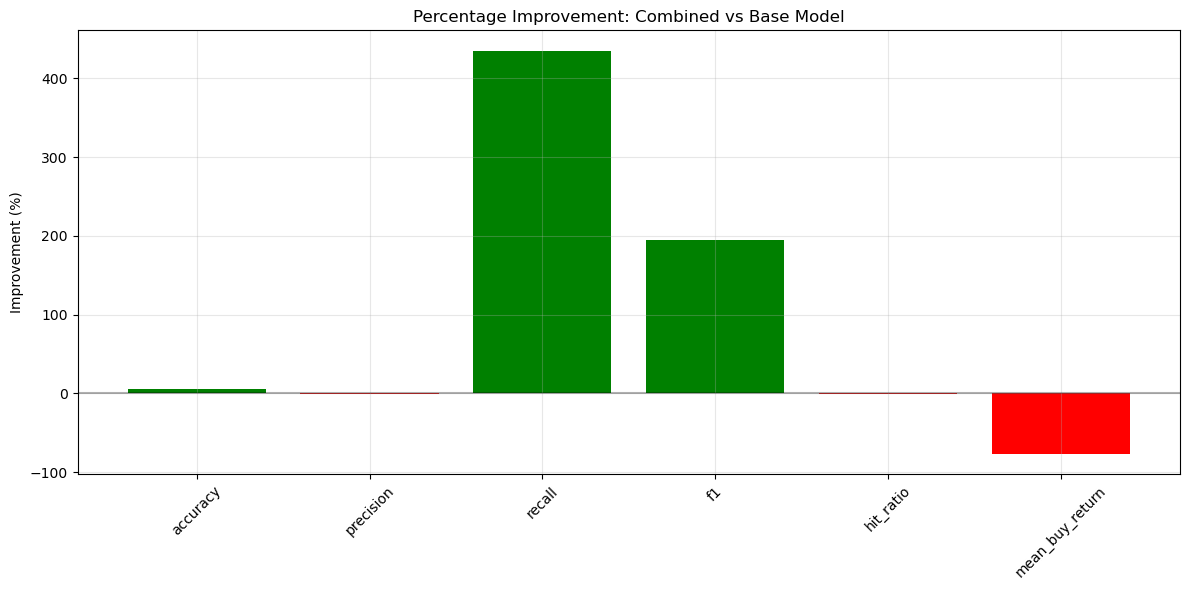


Analyzing signals for AES...

--- AES Base Model Model Performance Metrics ---
Accuracy: 0.4976
Precision: 0.5053
Recall: 0.3763
F1 Score: 0.4314
Total Returns: 0.8501
Hit Ratio: 0.5053
Mean Buy Return: 0.0006
Max Drawdown: -0.4770

--- AES Combined Model Model Performance Metrics ---
Accuracy: 0.4955
Precision: 0.5015
Recall: 0.5975
F1 Score: 0.5453
Total Returns: 0.2822
Hit Ratio: 0.5015
Mean Buy Return: 0.0001
Max Drawdown: -0.5429
Plot saved to weather_data\AES_signals.png


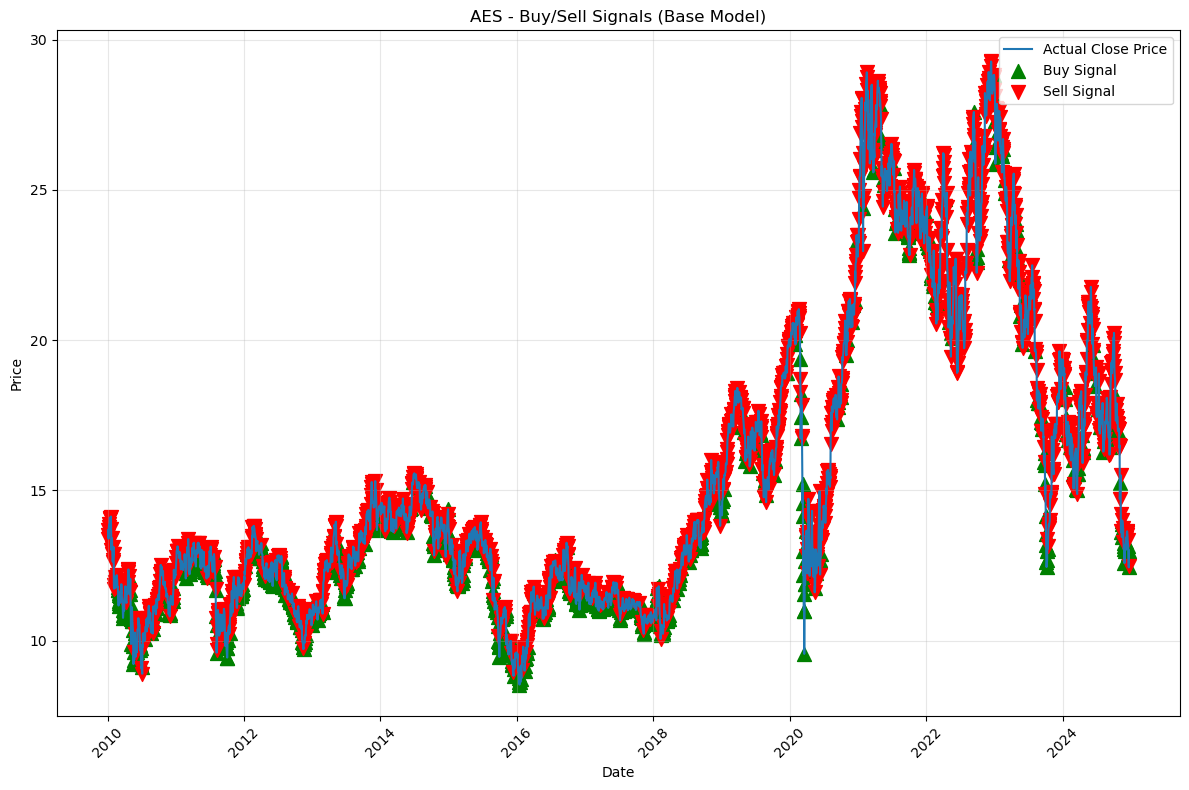

Plot saved to weather_data\AES_signals.png


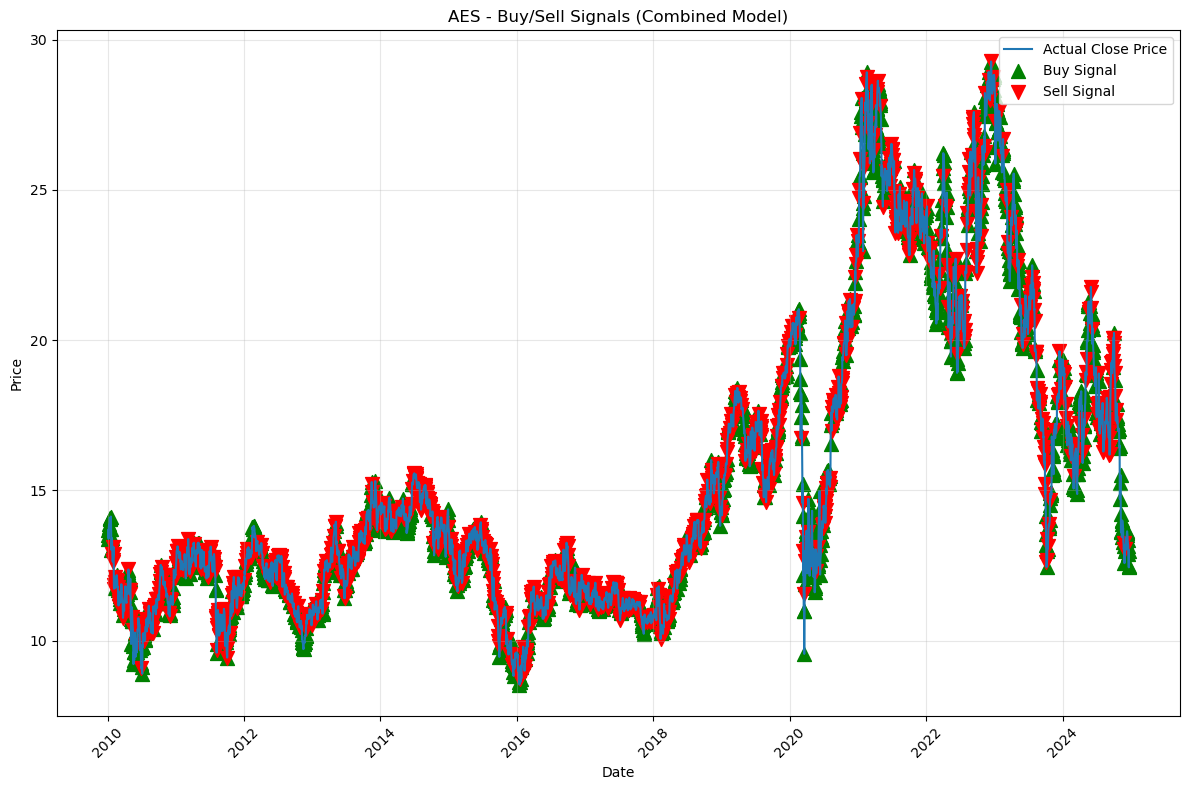


--- Model Comparison ---
            Metric  Base Model  Combined Model  Improvement  Pct_Improvement
0         accuracy    0.497611        0.495488    -0.002123        -0.426667
1        precision    0.505278        0.501540    -0.003738        -0.739822
2           recall    0.376310        0.597484     0.221174        58.774373
3               f1    0.431361        0.545324     0.113963        26.419490
4        hit_ratio    0.505278        0.501540    -0.003738        -0.739822
5  mean_buy_return    0.000599        0.000124    -0.000474       -79.252460


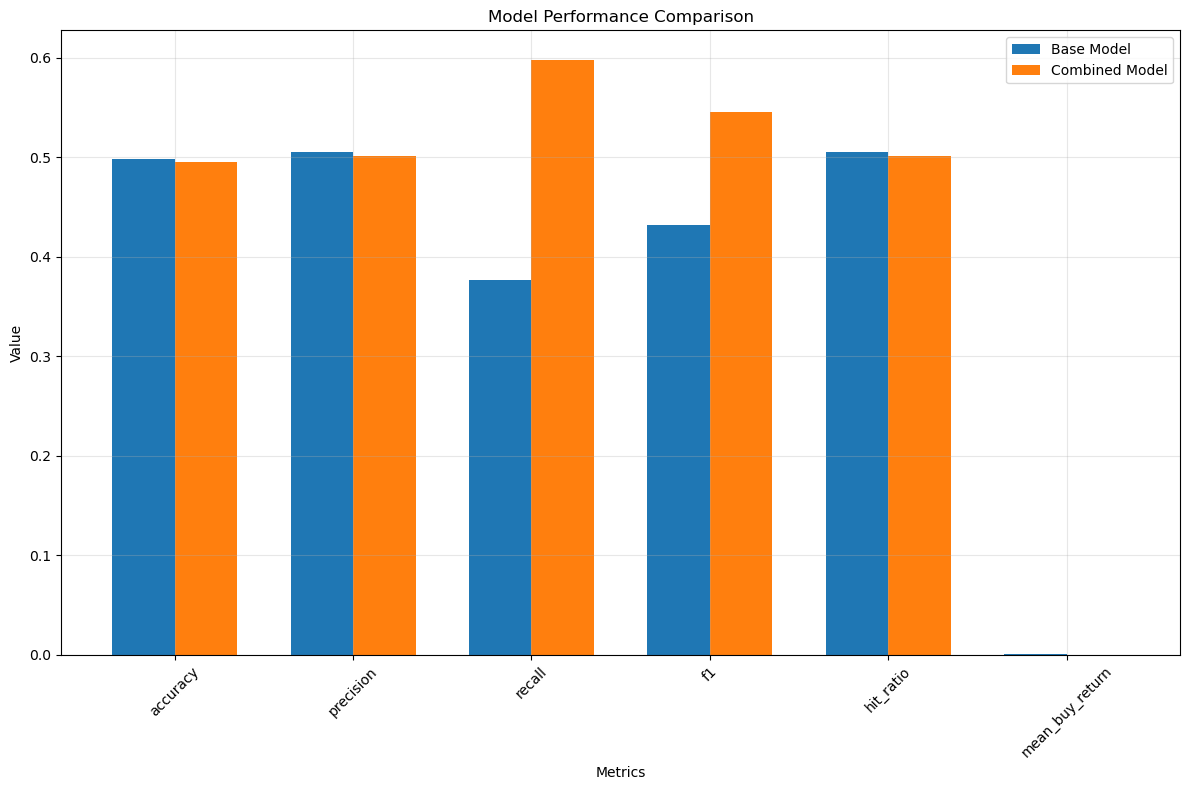

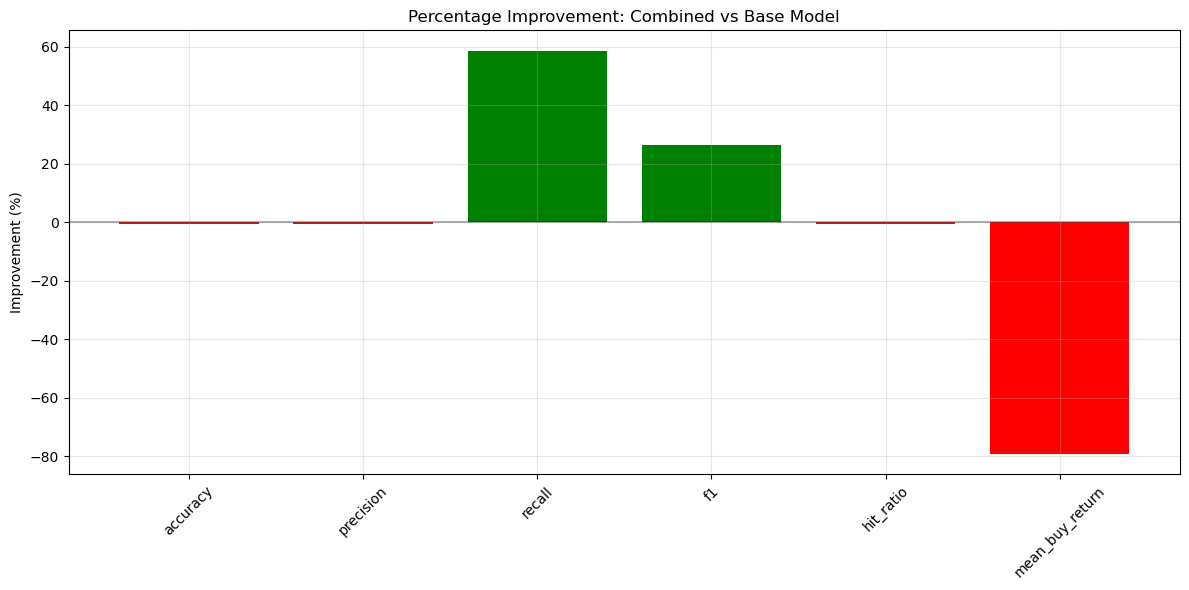


Analyzing signals for AJG...

--- AJG Base Model Model Performance Metrics ---
Accuracy: 0.4565
Precision: 0.4975
Recall: 0.0973
F1 Score: 0.1627
Total Returns: 0.1082
Hit Ratio: 0.4975
Mean Buy Return: 0.0003
Max Drawdown: -0.1839

--- AJG Combined Model Model Performance Metrics ---
Accuracy: 0.5204
Precision: 0.5527
Recall: 0.6129
F1 Score: 0.5812
Total Returns: 2.4411
Hit Ratio: 0.5527
Mean Buy Return: 0.0011
Max Drawdown: -0.1956
Plot saved to weather_data\AJG_signals.png


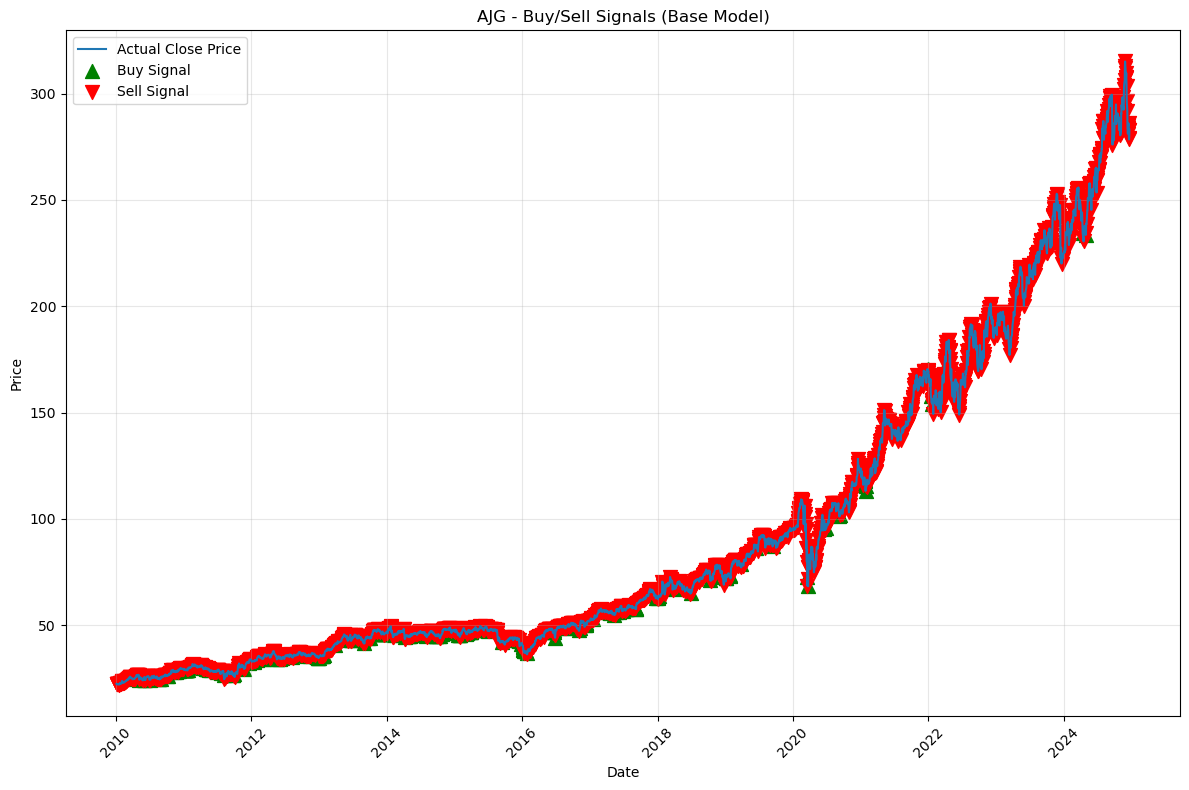

Plot saved to weather_data\AJG_signals.png


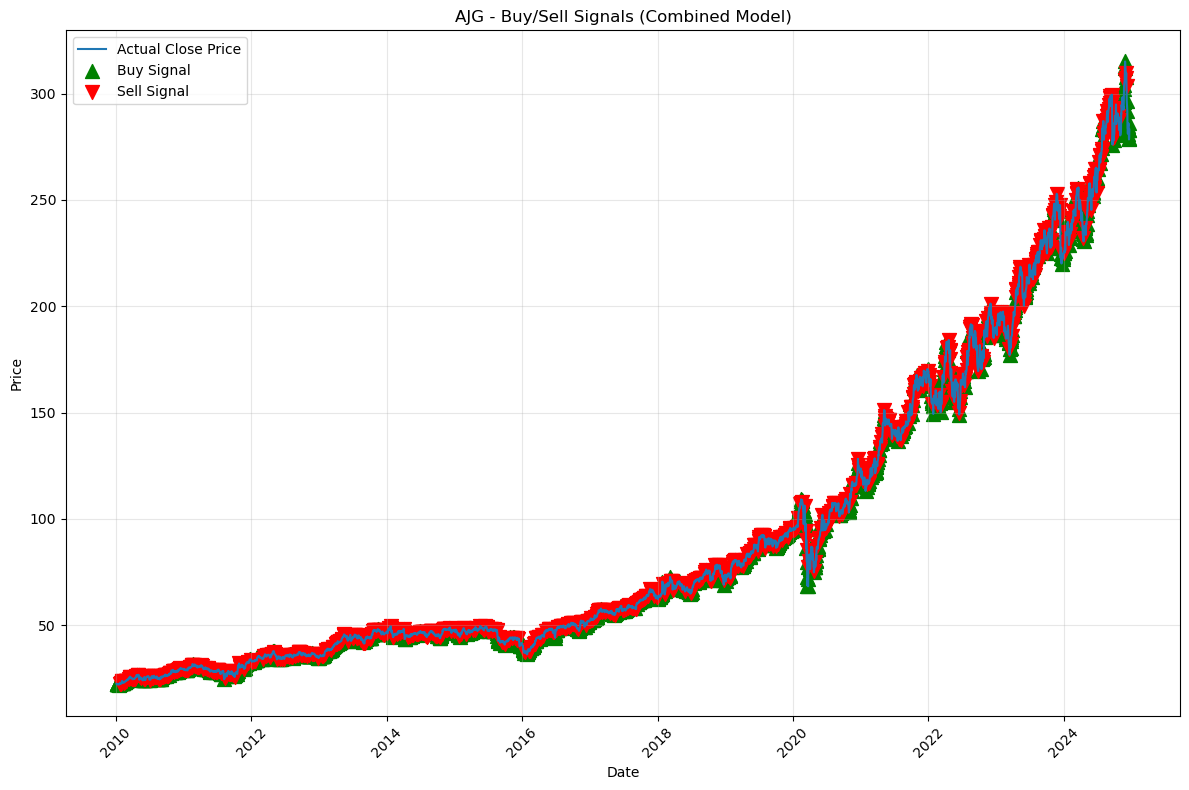


--- Model Comparison ---
            Metric  Base Model  Combined Model  Improvement  Pct_Improvement
0         accuracy    0.456476        0.520435     0.063960        14.011628
1        precision    0.497500        0.552666     0.055166        11.088718
2           recall    0.097263        0.612903     0.515640       530.150754
3               f1    0.162715        0.581228     0.418514       257.207125
4        hit_ratio    0.497500        0.552666     0.055166        11.088718
5  mean_buy_return    0.000270        0.001076     0.000806       298.079201


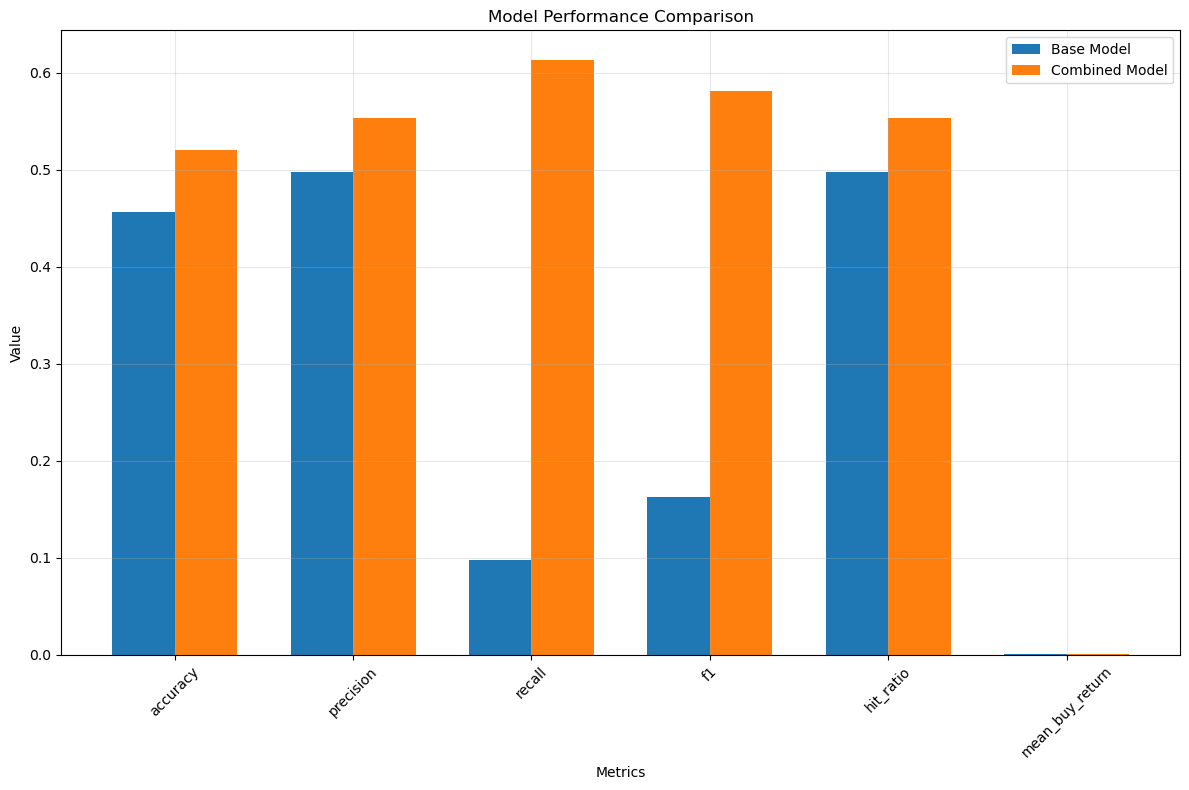

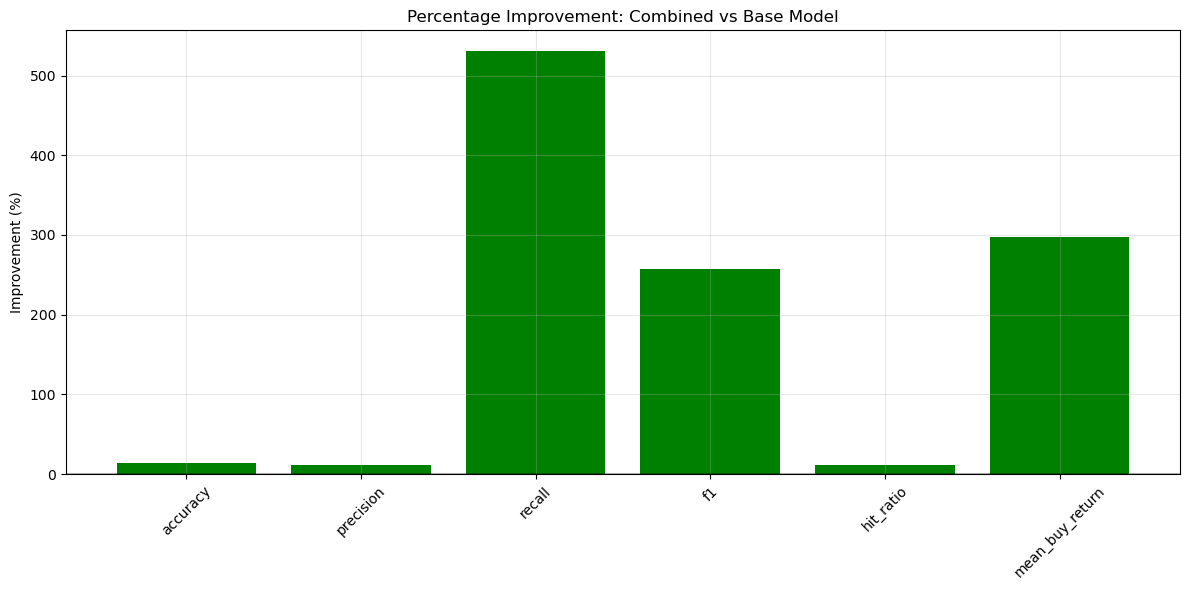


Performing aggregated analysis across all tickers...

--- ABBV Base Model Performance Metrics ---
Accuracy: 0.4625
Precision: 0.4757
Recall: 0.0303
F1 Score: 0.0570
Total Returns: 0.0074
Hit Ratio: 0.4757
Mean Buy Return: 0.0001
Max Drawdown: -0.1365

--- ABBV Combined Model Performance Metrics ---
Accuracy: 0.5255
Precision: 0.5512
Recall: 0.6167
F1 Score: 0.5821
Total Returns: 1.8551
Hit Ratio: 0.5512
Mean Buy Return: 0.0010
Max Drawdown: -0.3872

--- ABT Base Model Performance Metrics ---
Accuracy: 0.4801
Precision: 0.4927
Recall: 0.1034
F1 Score: 0.1710
Total Returns: 0.5255
Hit Ratio: 0.4927
Mean Buy Return: 0.0013
Max Drawdown: -0.1429

--- ABT Combined Model Performance Metrics ---
Accuracy: 0.5029
Precision: 0.5173
Recall: 0.6119
F1 Score: 0.5606
Total Returns: 0.9487
Hit Ratio: 0.5173
Mean Buy Return: 0.0004
Max Drawdown: -0.3389

--- ADM Base Model Performance Metrics ---
Accuracy: 0.4838
Precision: 0.5310
Recall: 0.1216
F1 Score: 0.1979
Total Returns: 0.6163
Hit Ratio: 0.53

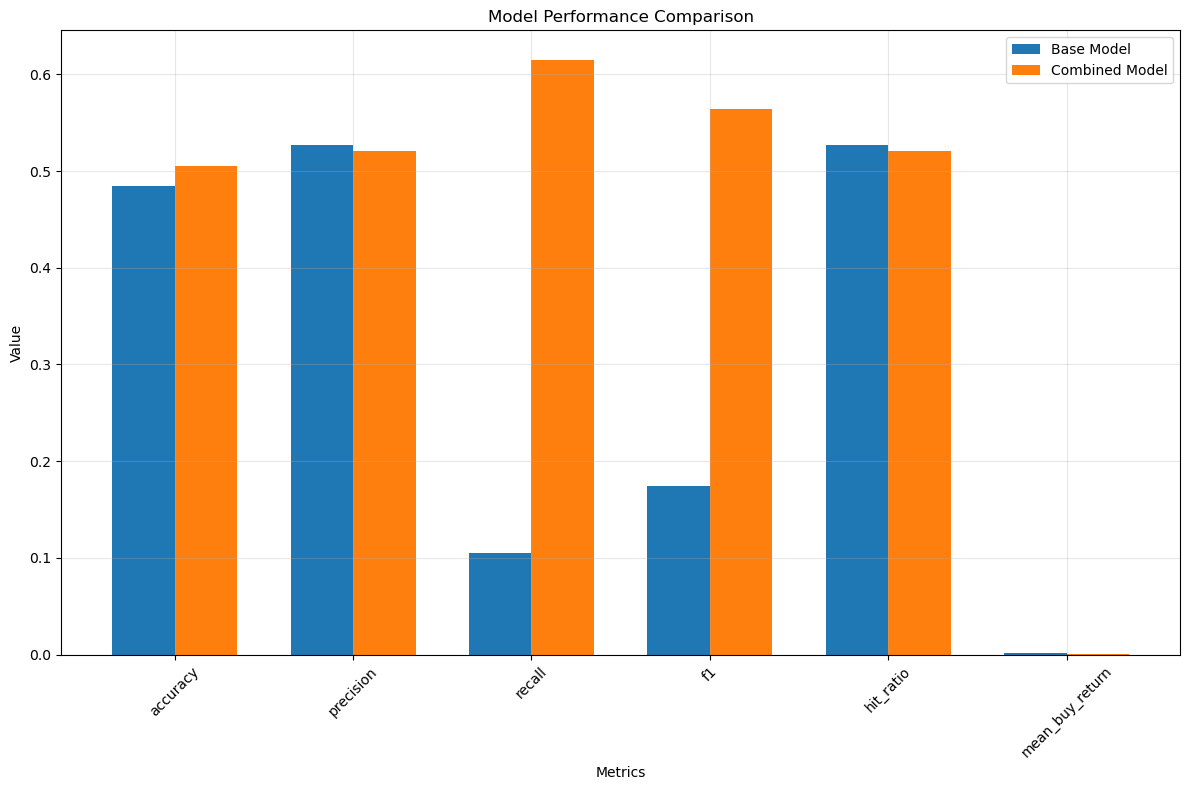

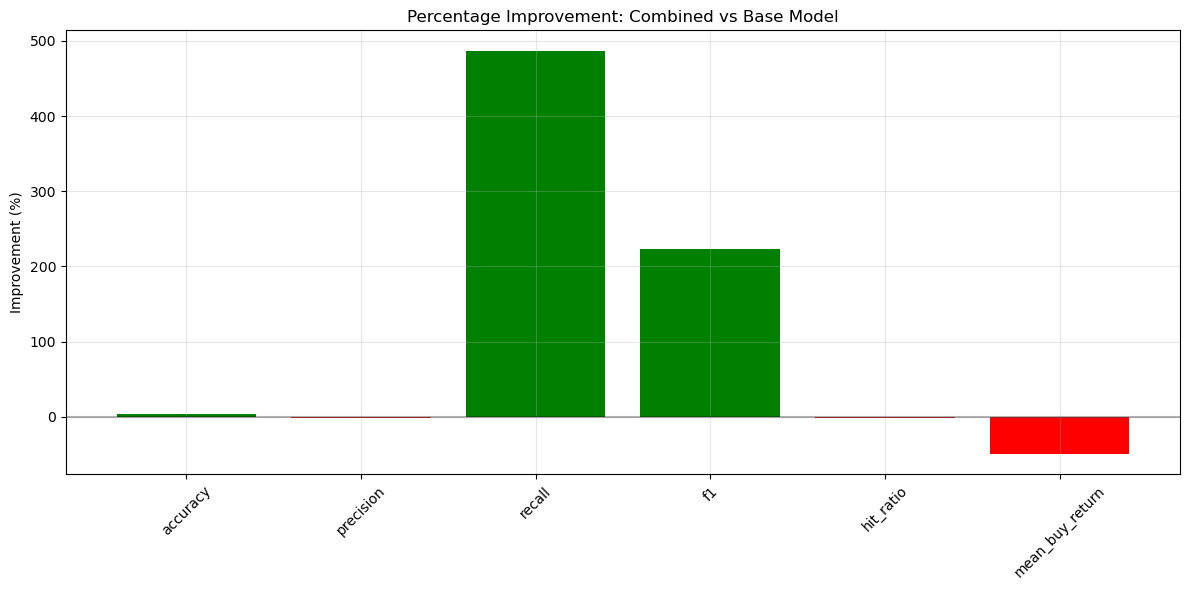


Signal generation and performance analysis complete!

Analyzing seasonal signal performance...


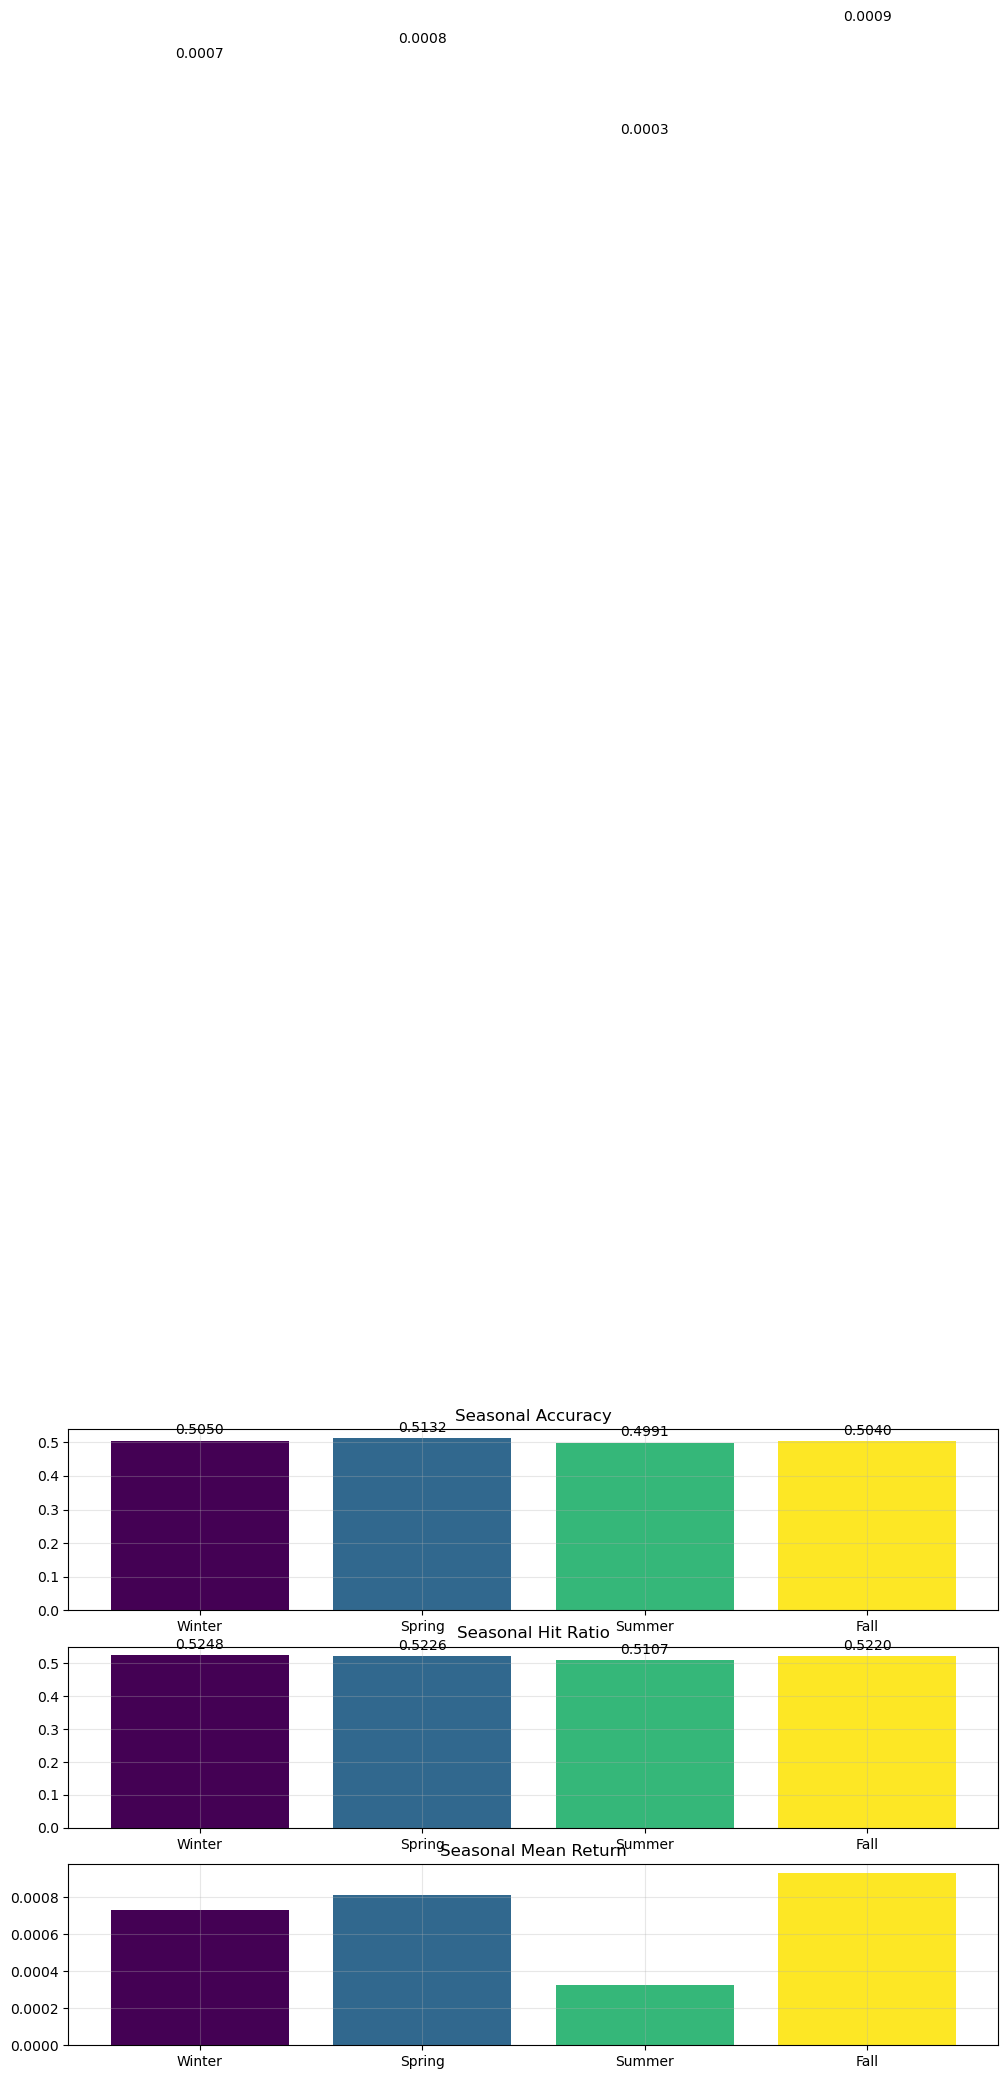


Seasonal performance analysis complete!


In [21]:
# Cell 17: Generate buy/sell signals and evaluate performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def generate_signals(model, X, y, ticker_data, feature_set_name):
    """
    Generate buy/sell signals based on model predictions and evaluate performance
    
    Parameters:
    -----------
    model : sklearn model
        Trained prediction model
    X : DataFrame
        Feature data
    y : Series
        Target labels
    ticker_data : DataFrame
        Stock data with dates and prices
    feature_set_name : str
        Name of the feature set used
        
    Returns:
    --------
    signals_df : DataFrame
        DataFrame with signals
    metrics : dict
        Performance metrics
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    # Predict using the model
    y_pred = model.predict(X)
    
    # Create signals dataframe
    signals_df = pd.DataFrame({
        'Date': ticker_data['Date'],
        'Ticker': ticker_data['Ticker'],
        'Close': ticker_data['Close'],
        'Actual': y,
        'Predicted': y_pred
    })
    
    # Convert signals to Buy/Sell
    signals_df['Signal'] = signals_df['Predicted'].map({1: 'Buy', 0: 'Sell'})
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred, zero_division=0),
        'recall': recall_score(y, y_pred, zero_division=0),
        'f1': f1_score(y, y_pred, zero_division=0)
    }
    
    # Calculate additional trading metrics
    signals_df['Next_Close'] = signals_df.groupby('Ticker')['Close'].shift(-1)
    signals_df['Return'] = signals_df.groupby('Ticker')['Close'].pct_change().shift(-1)
    
    # Trading returns based on signals (Buy = long, Sell = not in market)
    signals_df['Strategy_Return'] = 0.0
    signals_df.loc[signals_df['Signal'] == 'Buy', 'Strategy_Return'] = signals_df['Return']
    
    # Trading metrics
    metrics['total_returns'] = signals_df['Strategy_Return'].sum()
    metrics['hit_ratio'] = len(signals_df[(signals_df['Signal'] == 'Buy') & (signals_df['Return'] > 0)]) / \
                          max(1, len(signals_df[signals_df['Signal'] == 'Buy']))
    
    # Mean return on positive signals
    buy_returns = signals_df[signals_df['Signal'] == 'Buy']['Return']
    metrics['mean_buy_return'] = buy_returns.mean() if len(buy_returns) > 0 else 0
    
    # Max drawdown calculation
    if len(signals_df) > 0:
        # Create cumulative returns
        signals_df['Cum_Strategy_Return'] = (1 + signals_df['Strategy_Return']).cumprod()
        # Calculate drawdown
        signals_df['Cum_Max'] = signals_df['Cum_Strategy_Return'].cummax()
        signals_df['Drawdown'] = (signals_df['Cum_Strategy_Return'] / signals_df['Cum_Max']) - 1
        metrics['max_drawdown'] = signals_df['Drawdown'].min()
    else:
        metrics['max_drawdown'] = 0
    
    print(f"\n--- {feature_set_name} Model Performance Metrics ---")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"Total Returns: {metrics['total_returns']:.4f}")
    print(f"Hit Ratio: {metrics['hit_ratio']:.4f}")
    print(f"Mean Buy Return: {metrics['mean_buy_return']:.4f}")
    print(f"Max Drawdown: {metrics['max_drawdown']:.4f}")
    
    return signals_df, metrics

def plot_signals_for_ticker(signals_df, ticker, title=None, output_dir=None):
    """
    Plot buy/sell signals for a specific ticker
    
    Parameters:
    -----------
    signals_df : DataFrame
        DataFrame with signals
    ticker : str
        Ticker symbol to plot
    title : str, optional
        Title for the plot
    output_dir : str, optional
        Directory to save the plot
    """
    ticker_signals = signals_df[signals_df['Ticker'] == ticker].copy()
    
    if len(ticker_signals) == 0:
        print(f"No data available for ticker {ticker}")
        return
    
    # Sort by date
    ticker_signals = ticker_signals.sort_values('Date')
    
    plt.figure(figsize=(12, 8))
    
    # Plot price line
    plt.plot(ticker_signals['Date'], ticker_signals['Close'], label='Actual Close Price')
    
    # Plot buy signals
    buy_signals = ticker_signals[ticker_signals['Signal'] == 'Buy']
    plt.scatter(buy_signals['Date'], buy_signals['Close'], marker='^', color='green', 
                s=100, label='Buy Signal')
    
    # Plot sell signals
    sell_signals = ticker_signals[ticker_signals['Signal'] == 'Sell']
    plt.scatter(sell_signals['Date'], sell_signals['Close'], marker='v', color='red', 
                s=100, label='Sell Signal')
    
    # Add title and labels
    if title:
        plt.title(title)
    else:
        plt.title(f"{ticker} - Buy/Sell Signals on Price")
    
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Rotate date labels for better readability
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save the plot if output directory is provided
    if output_dir:
        output_path = os.path.join(output_dir, f'{ticker}_signals.png')
        plt.savefig(output_path)
        print(f"Plot saved to {output_path}")
    
    plt.show()

def compare_model_performance(base_metrics, combined_metrics, output_dir=None):
    """
    Compare performance metrics between base and combined models
    
    Parameters:
    -----------
    base_metrics : dict
        Performance metrics for base model
    combined_metrics : dict
        Performance metrics for combined model
    output_dir : str, optional
        Directory to save the comparison plot
    """
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'hit_ratio', 'mean_buy_return']
    
    # Create comparison dataframe
    comparison = pd.DataFrame({
        'Metric': metrics,
        'Base Model': [base_metrics[m] for m in metrics],
        'Combined Model': [combined_metrics[m] for m in metrics]
    })
    
    # Calculate improvement
    comparison['Improvement'] = comparison['Combined Model'] - comparison['Base Model']
    comparison['Pct_Improvement'] = (comparison['Improvement'] / comparison['Base Model']) * 100
    
    # Display comparison
    print("\n--- Model Comparison ---")
    print(comparison)
    
    # Visualization
    plt.figure(figsize=(12, 8))
    
    # Bar chart for model comparison
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, comparison['Base Model'], width, label='Base Model')
    plt.bar(x + width/2, comparison['Combined Model'], width, label='Combined Model')
    
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    plt.title('Model Performance Comparison')
    plt.xticks(x, metrics, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save the plot if output directory is provided
    if output_dir:
        plt.savefig(os.path.join(output_dir, 'model_comparison.png'))
    
    plt.show()
    
    # Visualize improvement
    plt.figure(figsize=(12, 6))
    colors = ['green' if x > 0 else 'red' for x in comparison['Improvement']]
    plt.bar(comparison['Metric'], comparison['Pct_Improvement'], color=colors)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title('Percentage Improvement: Combined vs Base Model')
    plt.ylabel('Improvement (%)')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save the plot if output directory is provided
    if output_dir:
        plt.savefig(os.path.join(output_dir, 'model_improvement.png'))
    
    plt.show()
    
    return comparison

# Execute signal generation and performance analysis
print("Generating signals and analyzing performance...")

# First, we need to prepare the data by including the ticker information
# Get a sample ticker for demonstration (you can modify this to analyze specific tickers)
sample_tickers = combined_df['Ticker'].unique()[:5]  # Take first 5 tickers for demonstration

for ticker in sample_tickers:
    print(f"\nAnalyzing signals for {ticker}...")
    ticker_data = combined_df[combined_df['Ticker'] == ticker].copy()
    
    if len(ticker_data) < 30:
        print(f"Not enough data for {ticker}, skipping...")
        continue
    
    # Use features and models we've already created
    ticker_X_base = ticker_data[base_features]
    ticker_X_all = ticker_data[all_features]
    ticker_y = ticker_data['Target']
    
    # Generate signals using base model (stock-only)
    ticker_base_signals, ticker_base_metrics = generate_signals(
        base_model, ticker_X_base, ticker_y, ticker_data, f"{ticker} Base Model"
    )
    
    # Generate signals using combined model (stock + weather)
    ticker_all_signals, ticker_all_metrics = generate_signals(
        all_model, ticker_X_all, ticker_y, ticker_data, f"{ticker} Combined Model"
    )
    
    # Plot signals for visualization
    plot_signals_for_ticker(ticker_base_signals, ticker, 
                           f"{ticker} - Buy/Sell Signals (Base Model)", 
                           weather_data_dir)
    
    plot_signals_for_ticker(ticker_all_signals, ticker, 
                           f"{ticker} - Buy/Sell Signals (Combined Model)", 
                           weather_data_dir)
    
    # Compare model performance
    ticker_comparison = compare_model_performance(
        ticker_base_metrics, ticker_all_metrics, weather_data_dir
    )
    
    # Save results
    ticker_base_signals.to_csv(os.path.join(weather_data_dir, f'{ticker}_base_signals.csv'), index=False)
    ticker_all_signals.to_csv(os.path.join(weather_data_dir, f'{ticker}_combined_signals.csv'), index=False)
    ticker_comparison.to_csv(os.path.join(weather_data_dir, f'{ticker}_model_comparison.csv'), index=False)

# Perform aggregated analysis across all tickers
print("\nPerforming aggregated analysis across all tickers...")

# Create consolidated signals dataframe
all_base_signals = []
all_combined_signals = []

for ticker in combined_df['Ticker'].unique():
    ticker_data = combined_df[combined_df['Ticker'] == ticker]
    
    if len(ticker_data) < 30:
        continue
        
    ticker_X_base = ticker_data[base_features]
    ticker_X_all = ticker_data[all_features]
    ticker_y = ticker_data['Target']
    
    # Generate signals
    try:
        base_signals, _ = generate_signals(base_model, ticker_X_base, ticker_y, ticker_data, f"{ticker} Base")
        all_base_signals.append(base_signals)
        
        combined_signals, _ = generate_signals(all_model, ticker_X_all, ticker_y, ticker_data, f"{ticker} Combined")
        all_combined_signals.append(combined_signals)
    except Exception as e:
        print(f"Error processing {ticker}: {e}")
        continue

# Combine all signals
if all_base_signals and all_combined_signals:
    consolidated_base = pd.concat(all_base_signals, ignore_index=True)
    consolidated_combined = pd.concat(all_combined_signals, ignore_index=True)
    
    # Calculate consolidated metrics
    consolidated_base_metrics = {
        'accuracy': accuracy_score(consolidated_base['Actual'], consolidated_base['Predicted']),
        'precision': precision_score(consolidated_base['Actual'], consolidated_base['Predicted'], zero_division=0),
        'recall': recall_score(consolidated_base['Actual'], consolidated_base['Predicted'], zero_division=0),
        'f1': f1_score(consolidated_base['Actual'], consolidated_base['Predicted'], zero_division=0),
        'hit_ratio': len(consolidated_base[(consolidated_base['Signal'] == 'Buy') & (consolidated_base['Return'] > 0)]) / 
                    max(1, len(consolidated_base[consolidated_base['Signal'] == 'Buy'])),
        'mean_buy_return': consolidated_base[consolidated_base['Signal'] == 'Buy']['Return'].mean(),
        'total_returns': consolidated_base['Strategy_Return'].sum(),
        'max_drawdown': consolidated_base['Drawdown'].min() if 'Drawdown' in consolidated_base.columns else 0
    }
    
    consolidated_combined_metrics = {
        'accuracy': accuracy_score(consolidated_combined['Actual'], consolidated_combined['Predicted']),
        'precision': precision_score(consolidated_combined['Actual'], consolidated_combined['Predicted'], zero_division=0),
        'recall': recall_score(consolidated_combined['Actual'], consolidated_combined['Predicted'], zero_division=0),
        'f1': f1_score(consolidated_combined['Actual'], consolidated_combined['Predicted'], zero_division=0),
        'hit_ratio': len(consolidated_combined[(consolidated_combined['Signal'] == 'Buy') & (consolidated_combined['Return'] > 0)]) / 
                     max(1, len(consolidated_combined[consolidated_combined['Signal'] == 'Buy'])),
        'mean_buy_return': consolidated_combined[consolidated_combined['Signal'] == 'Buy']['Return'].mean(),
        'total_returns': consolidated_combined['Strategy_Return'].sum(),
        'max_drawdown': consolidated_combined['Drawdown'].min() if 'Drawdown' in consolidated_combined.columns else 0
    }
    
    # Compare overall model performance
    print("\n--- Overall Model Performance Comparison ---")
    overall_comparison = compare_model_performance(
        consolidated_base_metrics, consolidated_combined_metrics, weather_data_dir
    )
    
    # Save consolidated results
    consolidated_base.to_csv(os.path.join(weather_data_dir, 'consolidated_base_signals.csv'), index=False)
    consolidated_combined.to_csv(os.path.join(weather_data_dir, 'consolidated_combined_signals.csv'), index=False)
    overall_comparison.to_csv(os.path.join(weather_data_dir, 'overall_model_comparison.csv'), index=False)
    
    print("\nSignal generation and performance analysis complete!")
else:
    print("No valid ticker data for signal generation.")

# Create a seasonal performance analysis
print("\nAnalyzing seasonal signal performance...")

if all_combined_signals:
    seasonal_df = pd.concat(all_combined_signals, ignore_index=True)
    
    # Check if 'season' column exists, if not, try to add it
    if 'season' not in seasonal_df.columns:
        # If Date column exists, we can compute the season
        if 'Date' in seasonal_df.columns:
            seasonal_df['month'] = pd.to_datetime(seasonal_df['Date']).dt.month
            seasonal_df['season'] = np.ceil(seasonal_df['month']/3).astype(int)
            seasonal_df['season'] = seasonal_df['season'].replace({5:1})  # Fix any values over 4
        else:
            # If we can't derive season, create a default one
            print("Warning: Unable to determine seasons from dates. Using default season.")
            seasonal_df['season'] = 1
    
    # Now map season numbers to names
    seasonal_df['Season'] = seasonal_df['season'].map(season_map)
    
    # Calculate seasonal performance
    seasonal_performance = []
    for season in seasonal_df['Season'].unique():
        season_data = seasonal_df[seasonal_df['Season'] == season]
        if len(season_data) > 0:
            performance = {
                'Season': season,
                'Accuracy': accuracy_score(season_data['Actual'], season_data['Predicted']),
                'Hit_Ratio': len(season_data[(season_data['Signal'] == 'Buy') & (season_data['Return'] > 0)]) / 
                            max(1, len(season_data[season_data['Signal'] == 'Buy'])),
                'Mean_Return': season_data[season_data['Signal'] == 'Buy']['Return'].mean(),
                'Total_Return': season_data['Strategy_Return'].sum(),
                'Sample_Size': len(season_data)
            }
            seasonal_performance.append(performance)
    
    seasonal_perf_df = pd.DataFrame(seasonal_performance)
    
    # Visualize seasonal performance
    plt.figure(figsize=(12, 8))
    
    metrics = ['Accuracy', 'Hit_Ratio', 'Mean_Return']
    
    for i, metric in enumerate(metrics):
        plt.subplot(3, 1, i+1)
        colors = plt.cm.viridis(np.linspace(0, 1, len(seasonal_perf_df)))
        bars = plt.bar(seasonal_perf_df['Season'], seasonal_perf_df[metric], color=colors)
        
        plt.title(f'Seasonal {metric.replace("_", " ")}')
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=0)
        
        # Add data labels on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.4f}', ha='center', va='bottom', rotation=0)
    
    plt.tight_layout()
    plt.savefig(os.path.join(weather_data_dir, 'seasonal_performance.png'))
    plt.show()
    
    # Save seasonal performance data
    seasonal_perf_df.to_csv(os.path.join(weather_data_dir, 'seasonal_performance.csv'), index=False)
    
    print("\nSeasonal performance analysis complete!")
else:
    print("No signals data available for seasonal analysis.")